Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary).

Do not leave any variable initialized to None.

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

## Make sure to name your notebook file (.ipynb) correctly:
### - HW4_UL_NAMESURNAME_ID (E.g. : HW4_UL_MARIOROSSI_2204567)

## Fill in your name, surname and id number (numero matricola) below:

In [1]:
NAME = "NIHAL SURI"
ID_number = int("2141819")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HOMEWORK #4

## Unsupervised learning

In this notebook we are going to explore the use of unsupervised clustering methods.

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs


In [3]:
# TODO 1: Write a function to compute the probability density function (pdf) of a gaussian random vector:
# you just need to apply its definition.

def gv_normalizing_const(sigma : np.ndarray) -> np.float64:
    '''
    Function to compute the normalization coefficient of a vector valued Gaussian distribution.
    :param sigma: Covariance of the Gaussian random vector (d x d Positive Definite matrix). 
    '''
    # YOUR CODE HERE
    # Normalizing constant for a multivariate gaussian distribution = 1/sqrt(det(2*pi*sigma))
    normalizing_const = 1 / np.sqrt(np.linalg.det(2*np.pi*sigma))
    return normalizing_const

def gaussian_pdf(x : np.ndarray, mu : np.ndarray, sigma : np.ndarray) -> np.ndarray:
    '''
    Function to compute the pdf of a vector valued gaussian distribution on the location x given its parameters, 
    mu and sigma. We are assuming sigma is invertible (you do not need to check its invertibility). For simplicity
    return the pdf with shape (1,1), this should be the shape you get after the quadratic form computation. 
    '''
    # YOUR CODE HERE
    # Formula for multivariable unnormalized pdf = exp(-0.5 * (x - mu).T * sigma^-1 * (x - mu))
    unnomrmalized_pdf = np.exp(-0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu))
    return gv_normalizing_const(sigma) * unnomrmalized_pdf

In [4]:
assert type(gv_normalizing_const(np.array([[2.]]))) == np.float64
# Test on scalar case
x = np.array([[1.]])
mean, cov = np.array([[2.5]]), np.array([[0.5]])
assert np.isclose(multivariate_normal.pdf(1, mean=mean, cov=cov), gaussian_pdf(x, mean, cov), atol=1e-3)

# Test on vector valued case
mean, temp = np.random.normal(2, 3, 2).reshape(-1,1), np.random.normal(2, 3, 4).reshape(2,2)
x = np.random.normal(2, 3, 2).reshape(-1,1)
cov = temp @ temp.T
hand_pdf = gaussian_pdf(x, mean, cov)
scipy_pdf = multivariate_normal.pdf(x.reshape(1,-1)[0], mean.reshape(1,-1)[0], cov)
assert np.isclose(hand_pdf, scipy_pdf, atol=1e-4)


Let's load a 1-D dataset which does not contain any label. It has been generated using K clusters.

Can you tell how many clusters have been used by looking at the scatter plot?

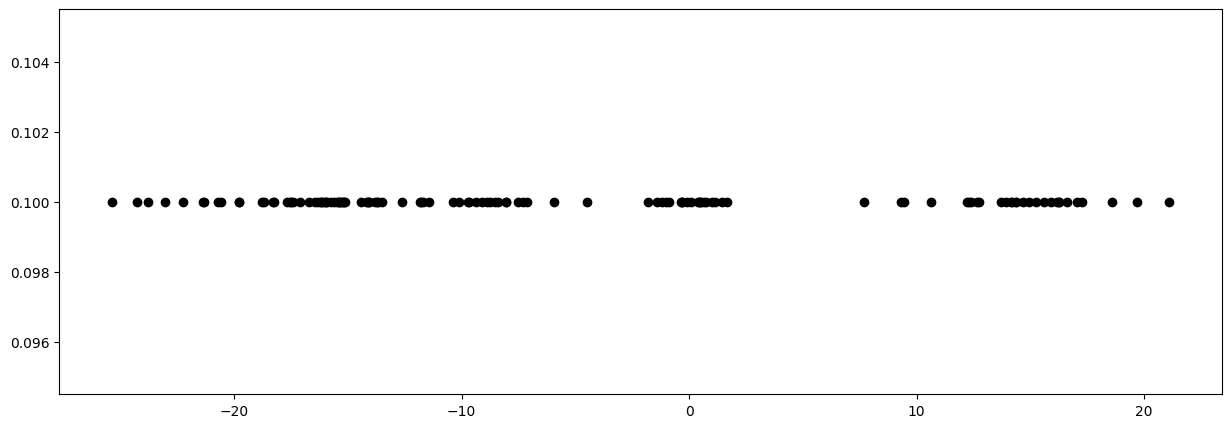

In [5]:
url = 'https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/HW_4/1_D_dataset.csv'
data = np.array(pd.read_csv(url, sep=';'))

plt.figure(figsize=(15,5))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='k')

It's not trivial to understand how many clusters are present. Such an issue is present also in the case of Expectation-Maximization (EM) on Gaussian Mixture Models (GMM) (the one we are going to implement) and K-means: for both of these algorithms the number of clusters is fixed a priori, it is a parameter (hyper-parameter) we must decide before processing any data.

Usually, in order to achieve satisfactory clustering, one needs to try with different number of classes and validate which is the best number. 

For now let's make it simple and let's consider the dataset has 3 clusters.

In the following cell we shall parametrize 3 Gaussian random variables specifiying both means, covariances and mixing probabilities. Take a moment to understand the way these parameters are stored, since the EM implementation is built on this notation. For now, means, cov and mixing probabilities are chosen without any specific criteria: we will see how EM applied to GMM will provide us a suboptimal set of means, covariances and mixing probabilities.

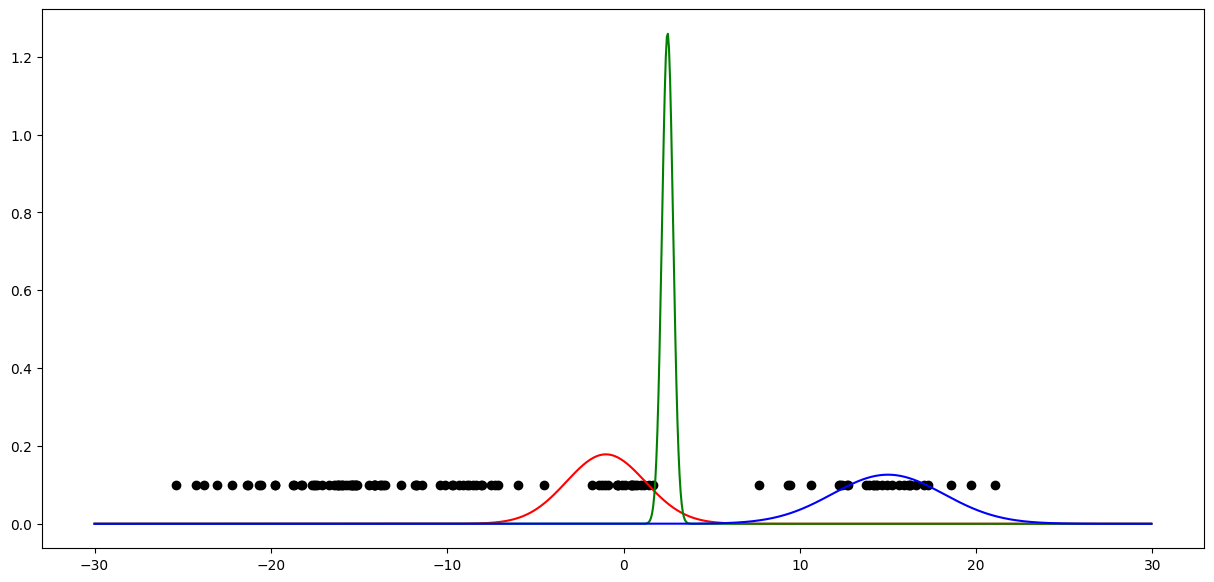

In [6]:
means = np.array([[-1],[2.5],[15]])      # shape (K,d)
covs  = np.array([[[5]],[[0.1]],[[10]]]) # shape (K,d,d) 
pi    = np.array([1/2, 1/4, 1/4])        # shape (K,)

X = np.linspace(-30, 30, 1000, endpoint=False).reshape(-1,1)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='k')
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [7]:
print(means.shape, covs.shape, pi.shape)

(3, 1) (3, 1, 1) (3,)


In [8]:
# TODO 2: Write a function M_step which computes the M-step of the EM algorithm under a GMM. Refer 
# to the slides you can find on moodle (in which ALL the necessary steps and expressions are present).
# Start by looking at the function "M_step" and then build all the helper functions.

def update_pi(W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_pi = W.mean(axis=0, dtype=np.float64)
    return new_pi

def update_means(data : np.ndarray, W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    # double check before submission
    new_means = W.T @ data / W.sum(axis=0).reshape(-1, 1) # vector notation of formula in slides
    return new_means

def update_covs(data : np.ndarray, W : np.ndarray, new_means : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    # calculate covariance matrix for each cluster
    covariances = np.zeros((W.shape[1], data.shape[1], data.shape[1]))
    for l in range(W.shape[1]):
        diff = data - new_means[l] # (N X D)
        weighted = W[:, l][:, np.newaxis] * diff # (N X D)
        covariances[l] = (weighted.T @ diff) / W[: , l].sum() # (D x D)

    new_covs = covariances
    return new_covs

def M_step(data : np.ndarray, W : np.ndarray) -> tuple:
    '''
    Function to compute the Maximization step on a GMM (use the expressions derived on the slides).
    :param data: Dataset N x d (d := number of features)
    :param W: Weight matrix N x K (K :=number of classes). Element in position (i,j) represents the probability of
              i-th datum to belong to class j (j-th cluster) given the current parameters: pi, means, covs
    :returns: (new_pi, new_mu, new_cov)
        WHERE:
        new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    new_pi    = update_pi(W)
    new_means = update_means(data, W)
    new_covs  = update_covs(data, W, new_means)
    
    return new_pi, new_means, new_covs 

In [9]:
W = np.array([[0.5, 0.5, 0],[0.5, 0, 0.5]])
assert np.isclose(update_pi(W), [0.5 , 0.25, 0.25], atol=1e-4).all()
W = np.random.normal(0,1, 1000).reshape(-1, 25) # Note this W is not normalized properly, we do not care not since we are testing only the output shape is correct
assert update_pi(W).shape == (25,)
# Test on the means update function
a = np.random.normal(0,1, 80).reshape(-1, 2)
b = update_means(a, W)
assert b.shape  == (25, 2)
# Test on the covs update function
assert update_covs(a, W, b).shape == (25, 2, 2)


In [10]:
# TODO 3: Write a function E_step which computes the E-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
def E_step(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray):
    '''
    Function to compute the Expectation step on a GMM model (use the expressions derived on the slides) given 
    the current values of the GMM parameters: pi, means, covs.
    :param data:  Same as M_step function.
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :returns: W, which is updated using the parameters of the GMM: pi, means, covs. W must be normalized (see 
              slides)
    '''
    # YOUR CODE HERE

    # calculation of W 

    N = data.shape[0] # nr of datapoints
    K = pi.shape[0] # nr of clusters

    # initialize W
    W = np.zeros((N, K))
    
    # loop over all clusters 
    for k in range(K): 
        for i in range(N):
            # pdf multiplied by the mixing probability for each datapoint
            W[i, k] = pi[k] * gaussian_pdf(data[i], means[k], covs[k])


    # normalization of W 
    W = W/np.sum(W, axis=1, keepdims=True)

    return W

In [11]:
assert E_step(data, pi, means, covs).shape == (119, 3)
assert np.isclose(np.sum(E_step(data, pi, means, covs).sum(1) - 1), 0, atol=1e-4)

In [12]:
# TODO 4: Write a function to randomly initialize the parameters of a GMM. This is necessary to start with the 
# EM iterations. 

def randomly_initialize_W(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    See random_init function docs.
    '''
    # YOUR CODE HERE

    N = data.shape[0]
    W = np.zeros((N, num_classes))

    # assign datapoints to clusters randomly 
    cluster_assign = np.arange(N) % num_classes # cyclic 
    np.random.shuffle(cluster_assign)

    # add excess datapoints if present to the last cluster (does not matter which cluster)
    exceeding_data = N % num_classes
    if exceeding_data > 0: 
        cluster_assign[-exceeding_data:] = num_classes - 1

    # set the weights in W (initially a hard assignment: assigning probability 1 for each datapoint)
    for i in range(N): 
        W[i, cluster_assign[i]] = 1
    return W

def random_init(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    Function to initialize W and GMM parameters. W is generated assigning randomly each datapoint only to one 
    cluster. We require to assign the same number of points for each cluster (even this is not striclty necessary
    to run the EM algorithm on GMM). If the number of data is not exactly divisible by the number of clusters 
    assign the exceeding data to one single class (it does not matter which one). 
    See M_step docs for details on W, interpretation and required shape.
    '''
    # Initialize W
    W = randomly_initialize_W(data, num_classes)
    # Use M_step to get GMM parameters
    pi, means, covs = M_step(data, W)
    return W, pi, means, covs

In [13]:
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,10), 5).sum(0) == 2).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 2).sum(0) == 10).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 3).sum(0) -6 == 2).any()

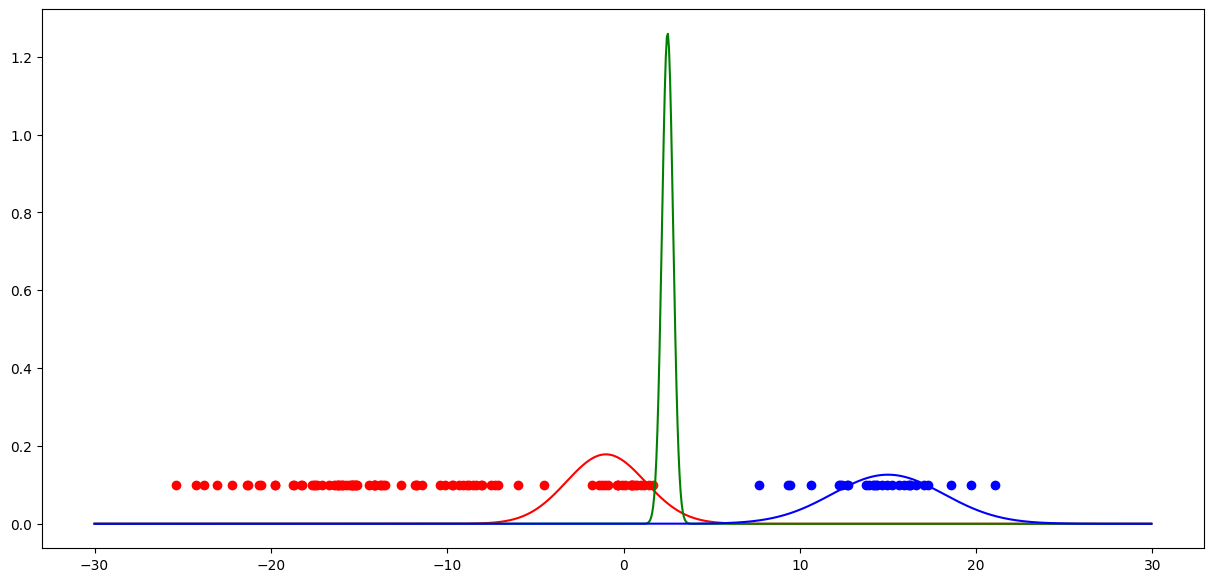

In [14]:
# Let's evaluate the class probability of each datum given current pi, means and covs. 
# Since we have 3 clusters we shall colour-code (rgb) each datum according to the class probabilities. Note that 
# it is not very likely to have a datum coming from the central (very peaked) distribution. 
W = E_step(data, pi, means, covs)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [15]:
# TODO 5: compute the log likelihood of an iid dataset under a GMM model.
def log_likelihood_GMM(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray) -> float:
    '''
    Function to compute the log likelihood for a set of iid observations under a GMM. Use the function you built
    before "gaussian_pdf" to compute the likelihood. 
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    '''
    # YOUR CODE HERE

    N = data.shape[0] # number of datapoints
    K = pi.shape[0] # nr of clusters

    # initialize 
    log_likelihood = 0.0

    for i in range(N):
        # prob of ith datum belonging to each cluster
        prob_x_per_cluster = 0.0
        for k in range(K): 
            prob_x_per_cluster += pi[k] * gaussian_pdf(data[i], means[k], covs[k])
        
        log_likelihood += np.log(prob_x_per_cluster)
    
    return log_likelihood

In [16]:
assert type(log_likelihood_GMM(data, pi, means, covs)) == np.float64

Iteration 0, log likelihood -473.2228,  delta log likelihood 0.0904
Iteration 1, log likelihood -473.1602,  delta log likelihood 0.0626
Iteration 2, log likelihood -473.0806,  delta log likelihood 0.0796
Iteration 3, log likelihood -472.9709,  delta log likelihood 0.1097
Iteration 4, log likelihood -472.8119,  delta log likelihood 0.1590
Iteration 5, log likelihood -472.5648,  delta log likelihood 0.2471
Iteration 6, log likelihood -472.1424,  delta log likelihood 0.4224
Iteration 7, log likelihood -471.3367,  delta log likelihood 0.8057
Iteration 8, log likelihood -469.6731,  delta log likelihood 1.6637
Iteration 9, log likelihood -466.4853,  delta log likelihood 3.1878
Iteration 10, log likelihood -462.1808,  delta log likelihood 4.3045
Iteration 11, log likelihood -457.9864,  delta log likelihood 4.1945
Iteration 12, log likelihood -454.6313,  delta log likelihood 3.3550
Iteration 13, log likelihood -452.9102,  delta log likelihood 1.7211
Iteration 14, log likelihood -452.2697,  del

Text(0, 0.5, 'Log likelihood')

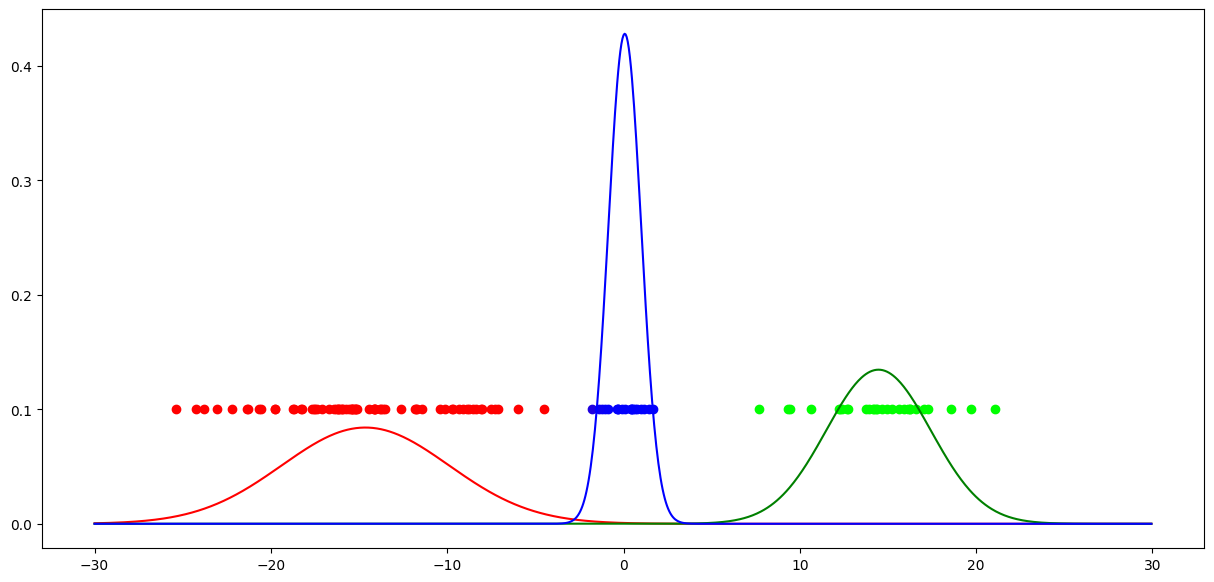

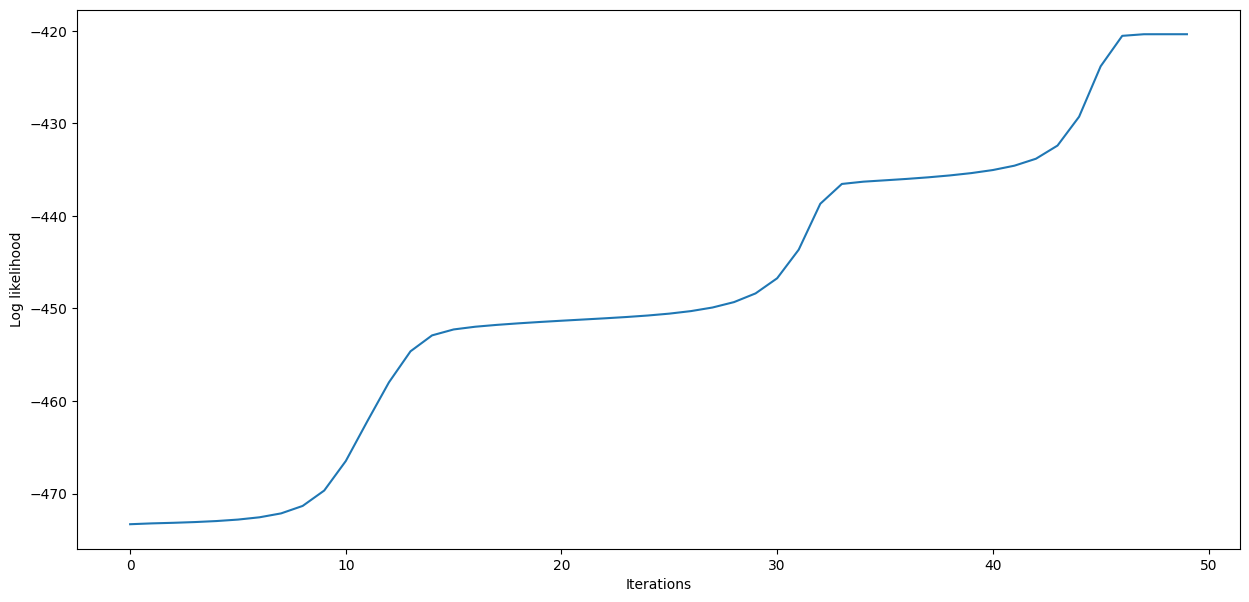

In [17]:
# TODO 6: Write a function to run the EM on GMM using the building blocks we created so far. Then test it on the 
# data we used so far (choose a meaningful max_iter, you do not need to exaggerate). 
def run_EM_on_GMM(data : np.ndarray, number_clusters : int, max_iter : int, epsilon : float = 1e-3,
                  plot_intermediate : bool = False) -> tuple:
    '''
    Function to run GMM on a given dataset and a given number of clusters. The termination conditions of the 
    iterative algorithm take into account either a specified max number of iterations or the improvement of the 
    log likelihood (if the log likelihood does not improve more than epsilon in two successive iterations we stop).
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param number_clusters: # of clusters (information we have a priori, before starting the EM)
    :param max_iter: Maximum number of iterations allowed to the EM.
    :param epsilon: Threshold on the improvement of the log likelihood
    :param plot_intermediate: Boolean used to plot intermediate GMM for 2-d datasets (you do not need to implement
                              anything).
    :returns: (W, pi, means, covs, log_likelihood_train)
        WHERE:
        W:     Optimal W     after EM reaches termination condition (same shape as M_step function).
        pi:    Optimal pi    after EM reaches termination condition (same shape as M_step function).
        means: Optimal means after EM reaches termination condition (same shape as M_step function).
        covs:  Optimal covs  after EM reaches termination condition (same shape as M_step function).
        log_likelihood_train: log likelihoods obtained during training (saved using a list). 
    '''
    W, pi, means, covs = random_init(data, number_clusters)
    log_likelihood_train = [log_likelihood_GMM(data, pi, means, covs)]
    num_iter = 0
    # Used to plot 2-d data
    if plot_intermediate:
        x_max = np.max(np.abs(X))
        x, y = np.mgrid[-x_max:x_max:.05, -x_max:x_max:.05]
        pos = np.dstack((x, y))
    
    while (True): 
        # Iterate with E-Step and M-step
        # YOUR CODE HERE
        
        W = E_step(data, pi, means, covs)
        pi, means, covs = M_step(data, W)
        
        # Save log likelihood given current GMM parameters
        log_likelihood_train.append(log_likelihood_GMM(data, pi, means, covs)) 

        if plot_intermediate:
            # Plot scatter plot of training data and corresponding clusters    
            fig = plt.figure(figsize=(15,7))
            for k in range(0, number_clusters):
                plt.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos))
            plt.scatter(data[0:,0], data[0:,1])
            plt.title(f'Iteration {num_iter}')
            
        print(f'Iteration {num_iter}, log likelihood {log_likelihood_train[-1]:.4f}, ' 
              f' delta log likelihood {(log_likelihood_train[-1] - log_likelihood_train[-2]):.4f}')
        num_iter += 1 
        
        # Use proper termination conditions, on: number of iteration or threshold on log likelihood improvement 
        # (use the break statement to stop while cycle)
        # YOUR CODE HERE
        if num_iter >= max_iter:
            print('Max iterations reached. stopping...')
            break     
        if np.abs(log_likelihood_train[-1] - log_likelihood_train[-2]) < epsilon:
            print('Convergence reached, stopping...')
            break 
    return W, pi, means, covs, log_likelihood_train

# Let's try our implementation of the EM algorithm
max_iter = 100  # to be overwritten
# YOUR CODE HERE
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(data, 3, max_iter, plot_intermediate=False)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

In [18]:
a, b, c, d, e = run_EM_on_GMM(data, 3, 10, plot_intermediate=False)
assert a.shape == (119, 3)
assert b.shape == (3,)
assert c.shape == (3, 1)
assert d.shape == (3, 1, 1)

Iteration 0, log likelihood -473.0197,  delta log likelihood 0.5158
Iteration 1, log likelihood -472.7049,  delta log likelihood 0.3149
Iteration 2, log likelihood -472.1545,  delta log likelihood 0.5503
Iteration 3, log likelihood -471.0182,  delta log likelihood 1.1364
Iteration 4, log likelihood -468.6478,  delta log likelihood 2.3703
Iteration 5, log likelihood -464.6545,  delta log likelihood 3.9933
Iteration 6, log likelihood -460.3048,  delta log likelihood 4.3497
Iteration 7, log likelihood -456.5432,  delta log likelihood 3.7616
Iteration 8, log likelihood -454.0385,  delta log likelihood 2.5047
Iteration 9, log likelihood -452.9788,  delta log likelihood 1.0597
Max iterations reached. stopping...


We shall now try the same procedure with a 2-dimensional dataset.

Everything is the same as before but we can appreciate a better visualization.

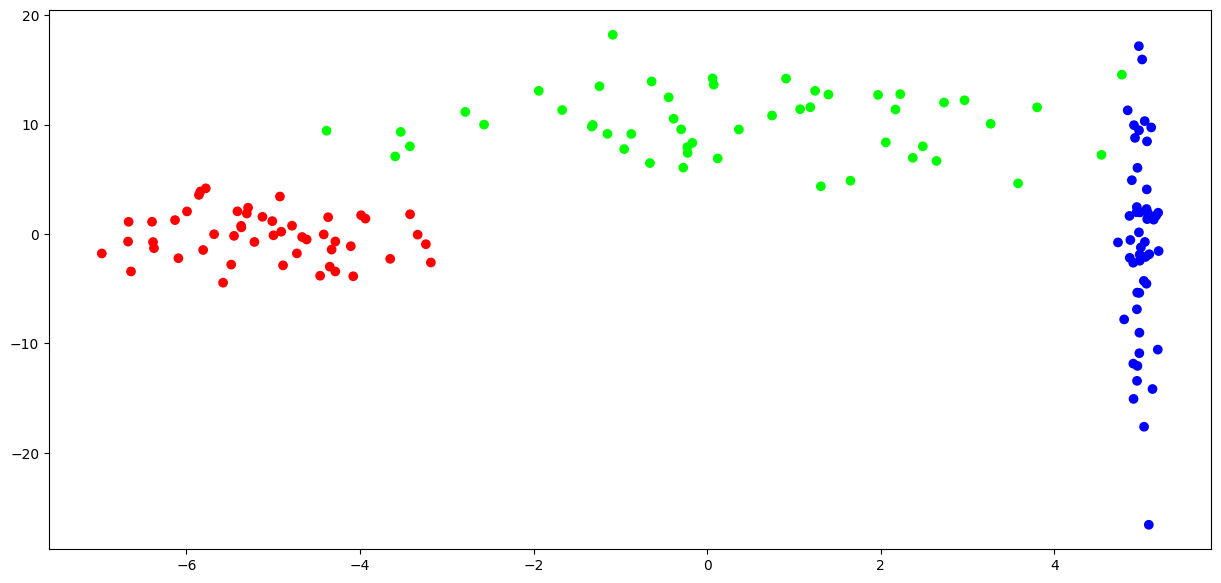

In [19]:
# Build the 2-D dataset.
K = 3
clusters_cov = [[1,2], [2,3], [0.1,10]]
centers = [[-5, 0], [0, 10.5], [5, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=ID_number, n_samples=150, shuffle=True)

colormap = np.array(['red', 'lime', 'blue'])

plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:,1], c = colormap[Y])

Iteration 0, log likelihood -941.5515,  delta log likelihood 5.0048
Iteration 1, log likelihood -934.0451,  delta log likelihood 7.5063
Iteration 2, log likelihood -923.7276,  delta log likelihood 10.3176
Iteration 3, log likelihood -907.9145,  delta log likelihood 15.8131
Iteration 4, log likelihood -886.1994,  delta log likelihood 21.7151
Iteration 5, log likelihood -867.9774,  delta log likelihood 18.2220
Iteration 6, log likelihood -848.2231,  delta log likelihood 19.7542
Iteration 7, log likelihood -826.9288,  delta log likelihood 21.2944
Iteration 8, log likelihood -799.3631,  delta log likelihood 27.5657
Iteration 9, log likelihood -763.5188,  delta log likelihood 35.8442
Iteration 10, log likelihood -747.8459,  delta log likelihood 15.6729
Iteration 11, log likelihood -739.5705,  delta log likelihood 8.2754
Iteration 12, log likelihood -734.5342,  delta log likelihood 5.0363
Iteration 13, log likelihood -730.0472,  delta log likelihood 4.4869
Iteration 14, log likelihood -723.9

c:\Users\Nihal\Documents\unipd\sem1\ml\MACHINE-LEARNING-2024-2025---INQ0091308---LABS\venv\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Iteration 20, log likelihood -707.3614,  delta log likelihood 0.0008
Convergence reached, stopping...


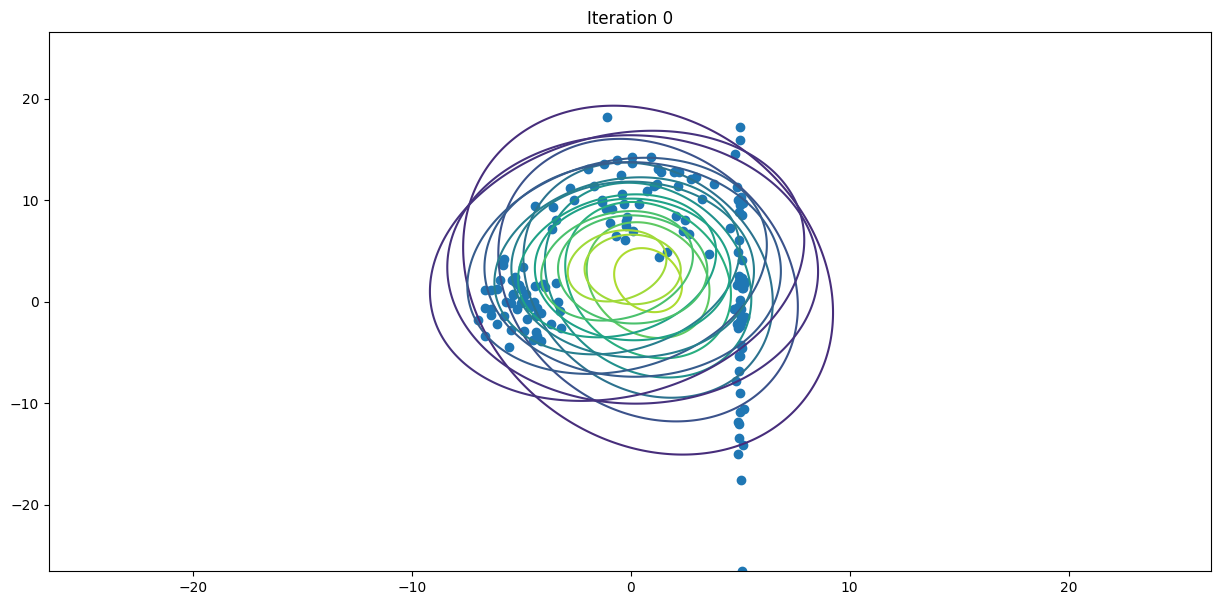

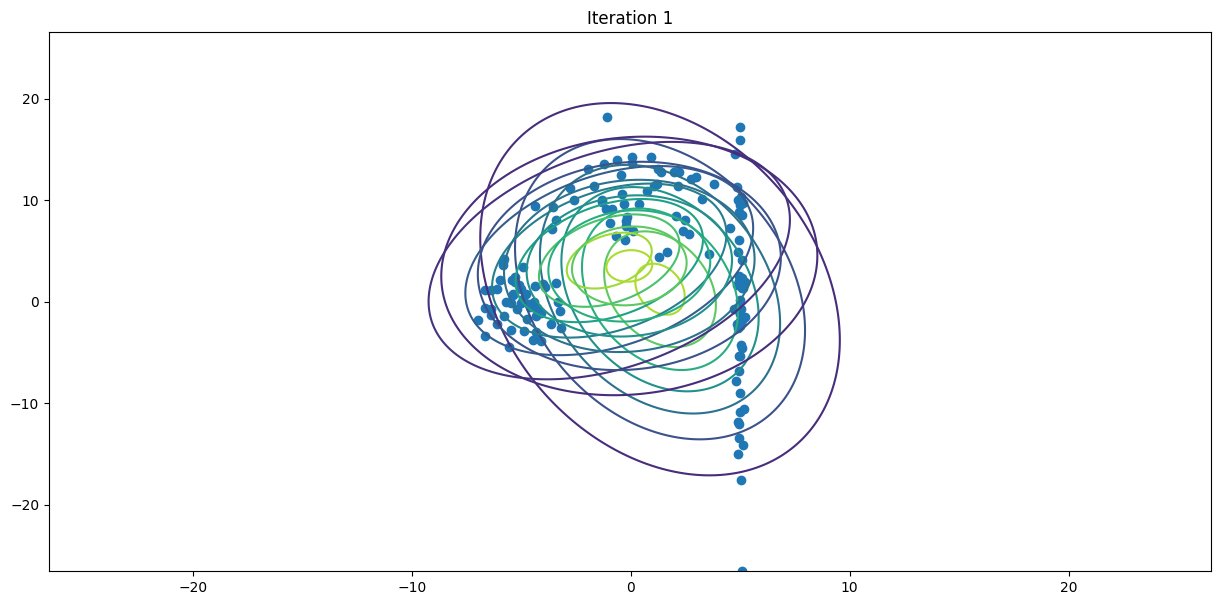

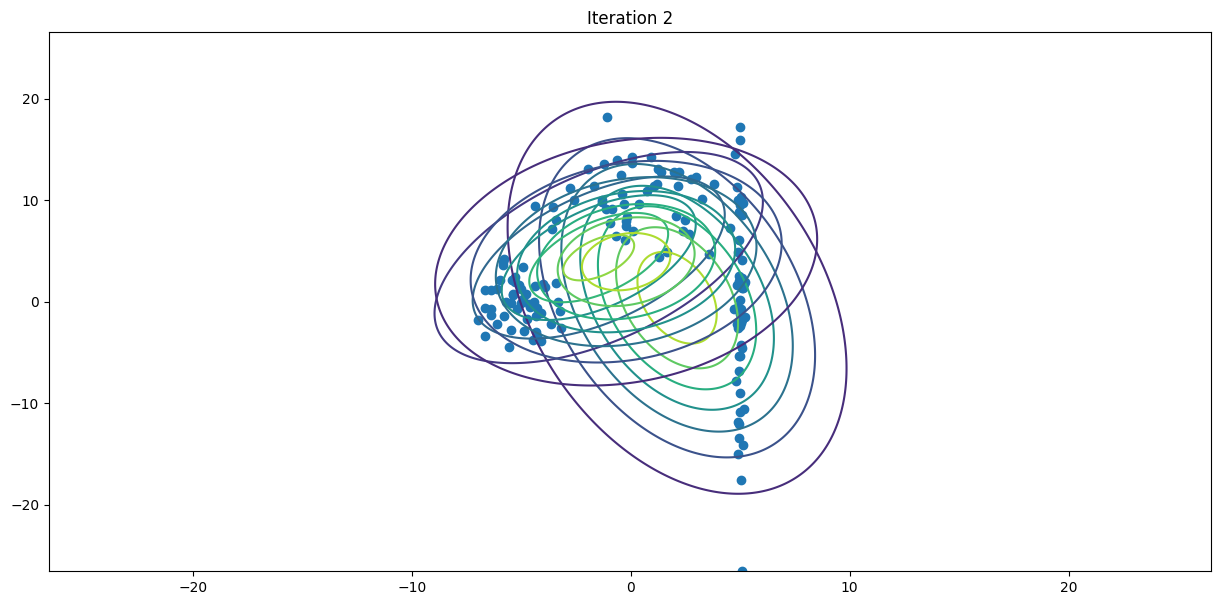

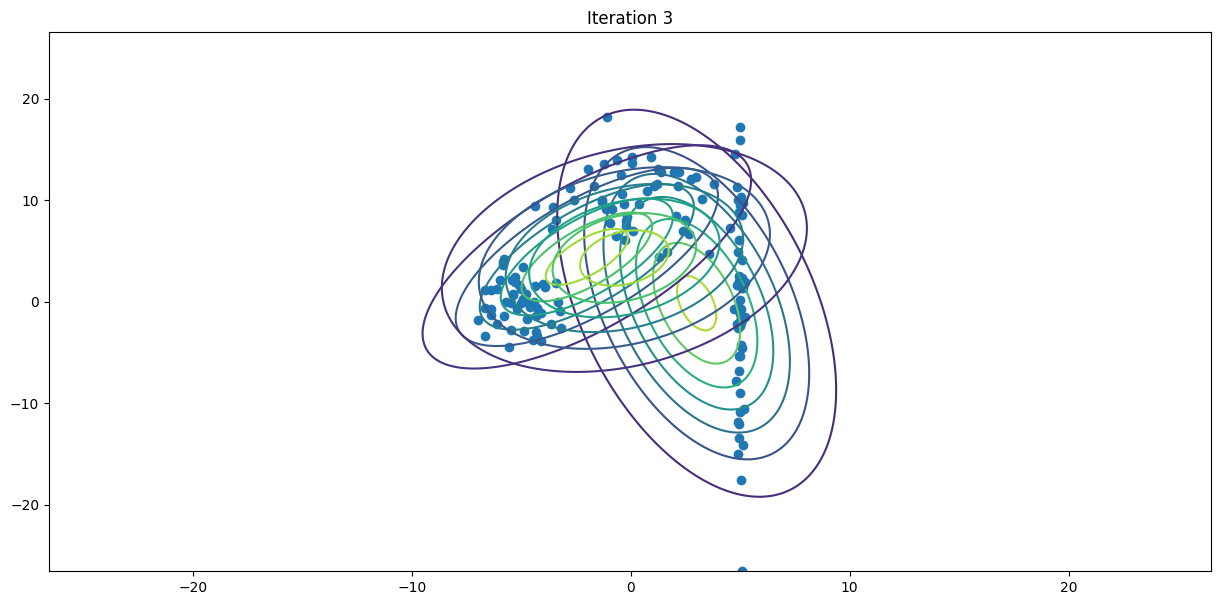

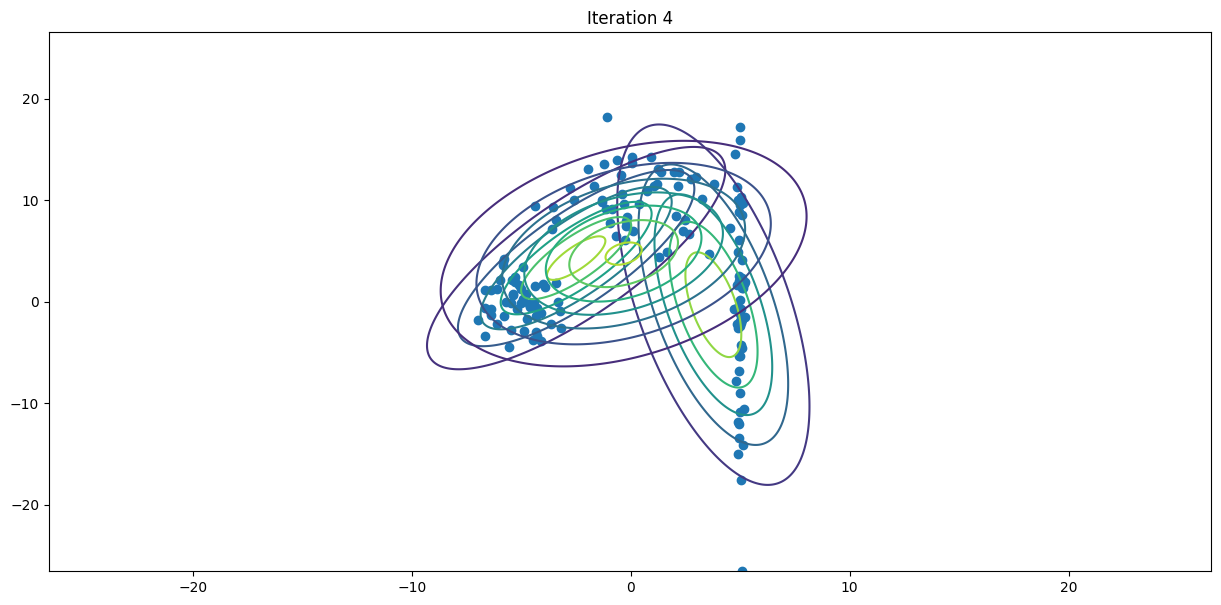

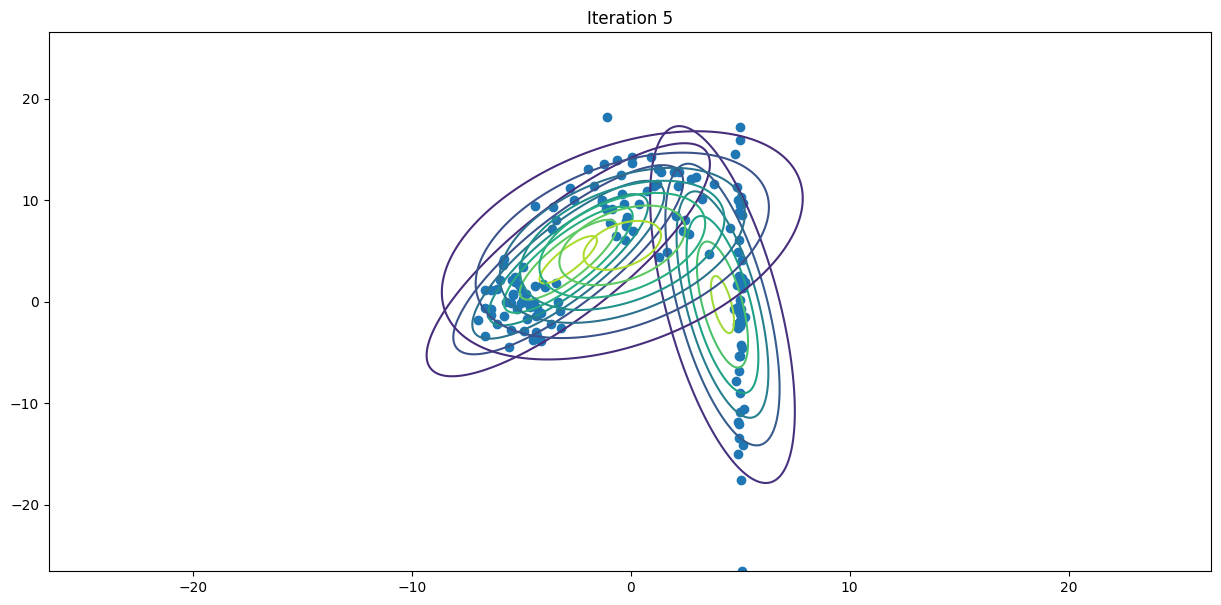

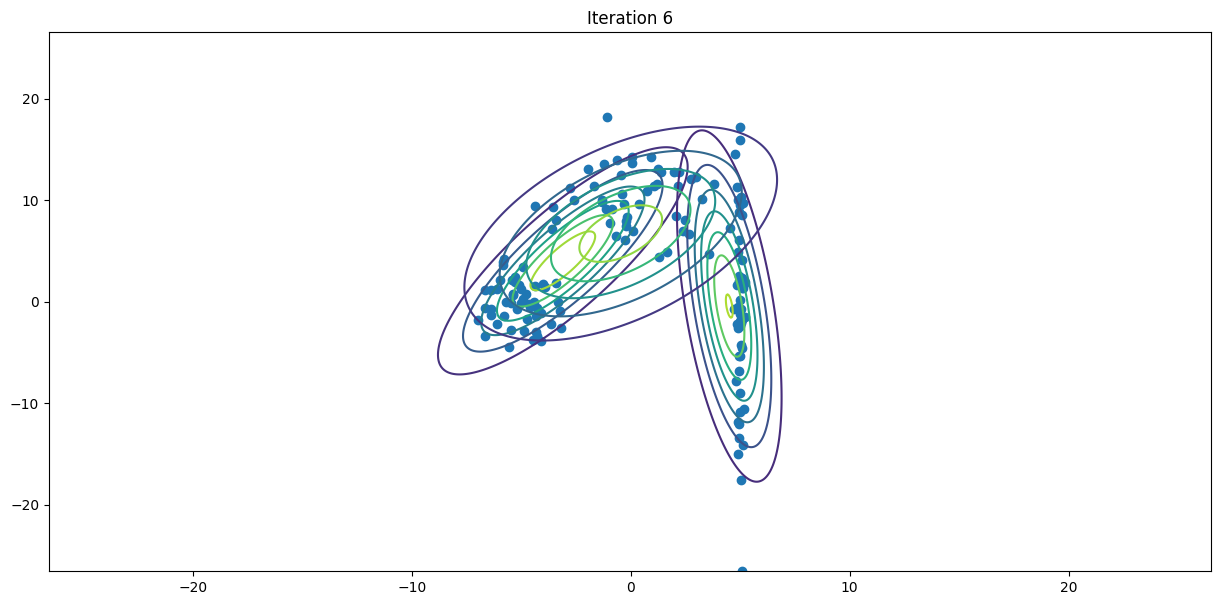

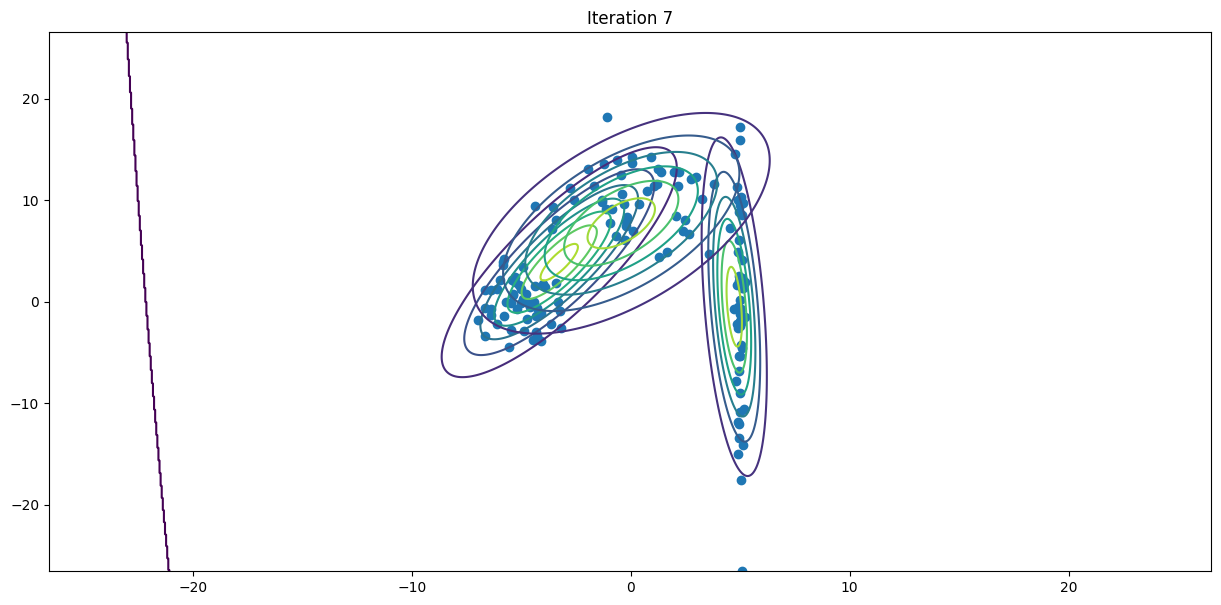

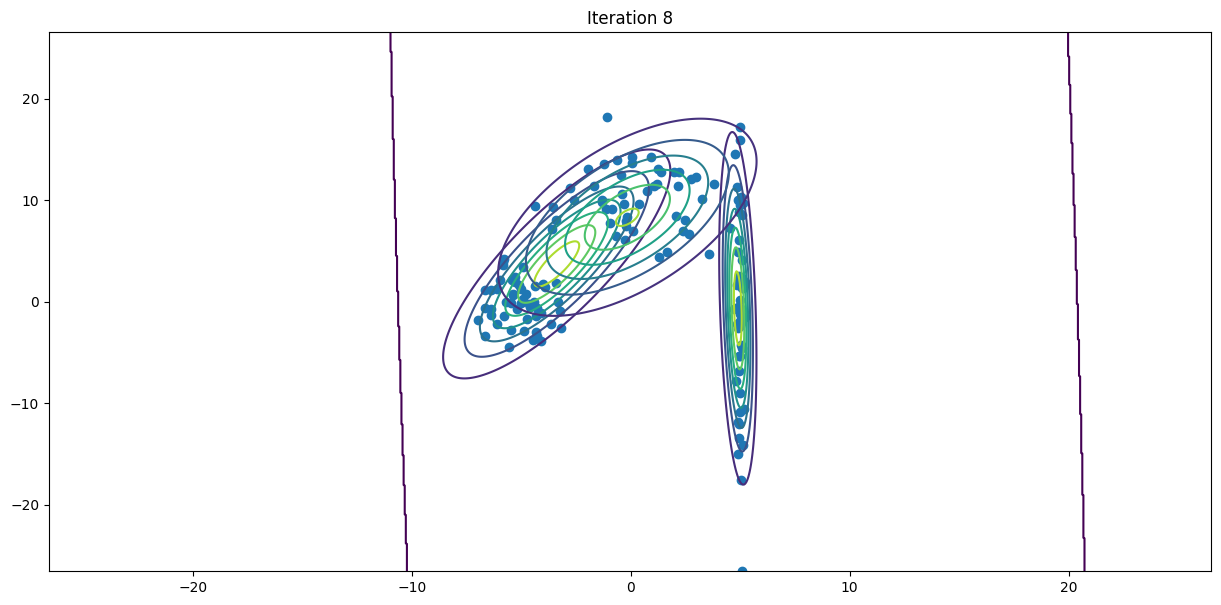

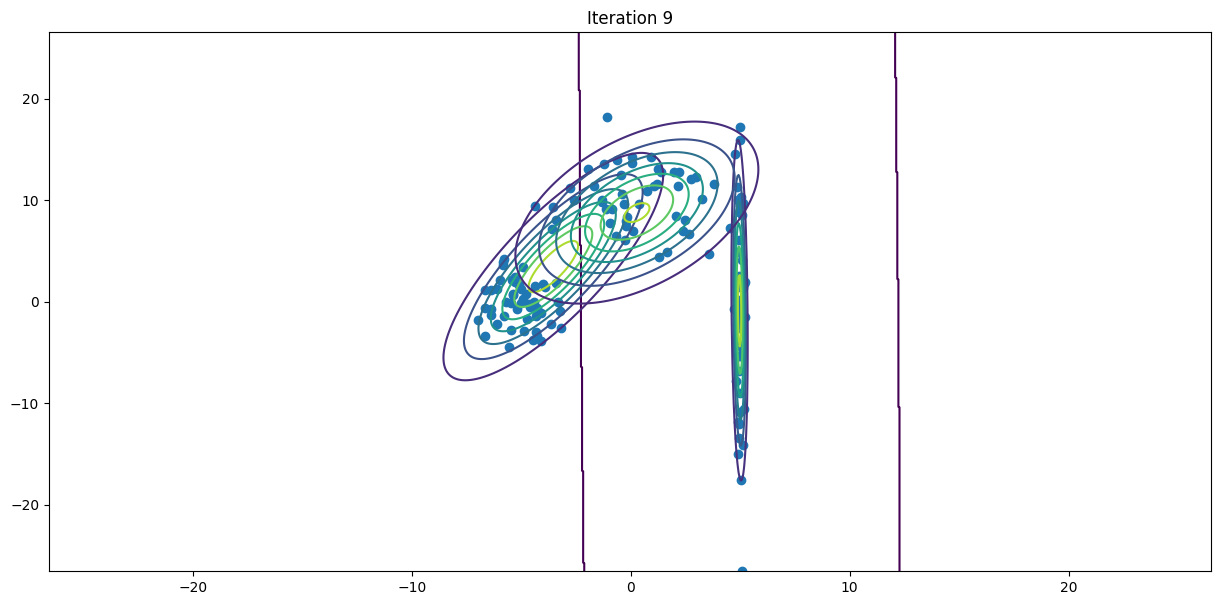

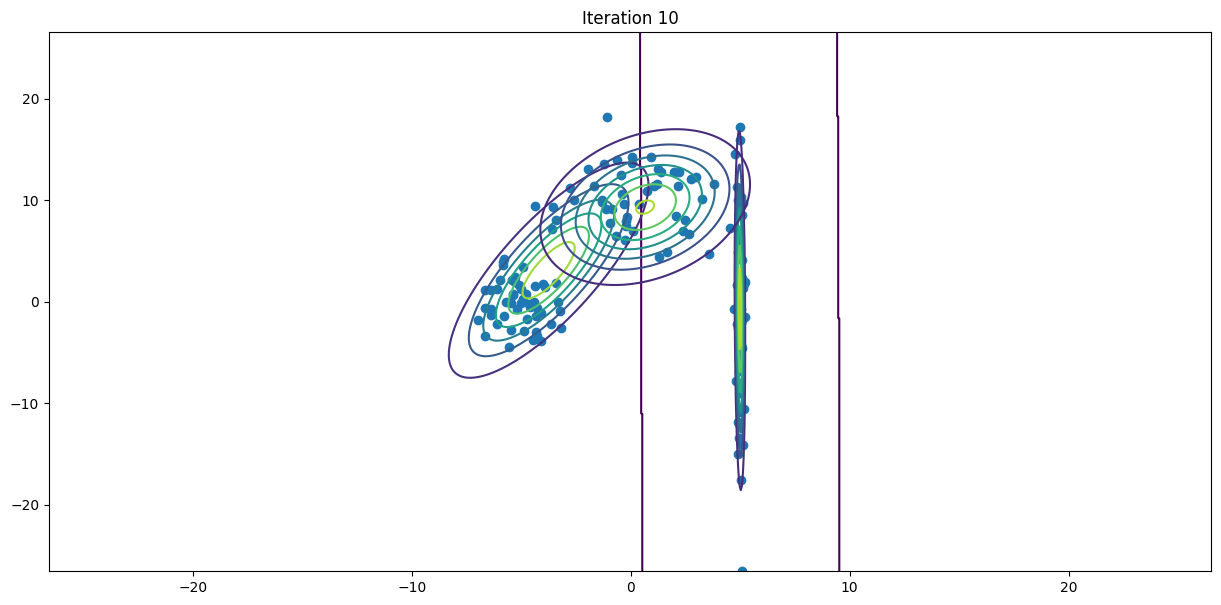

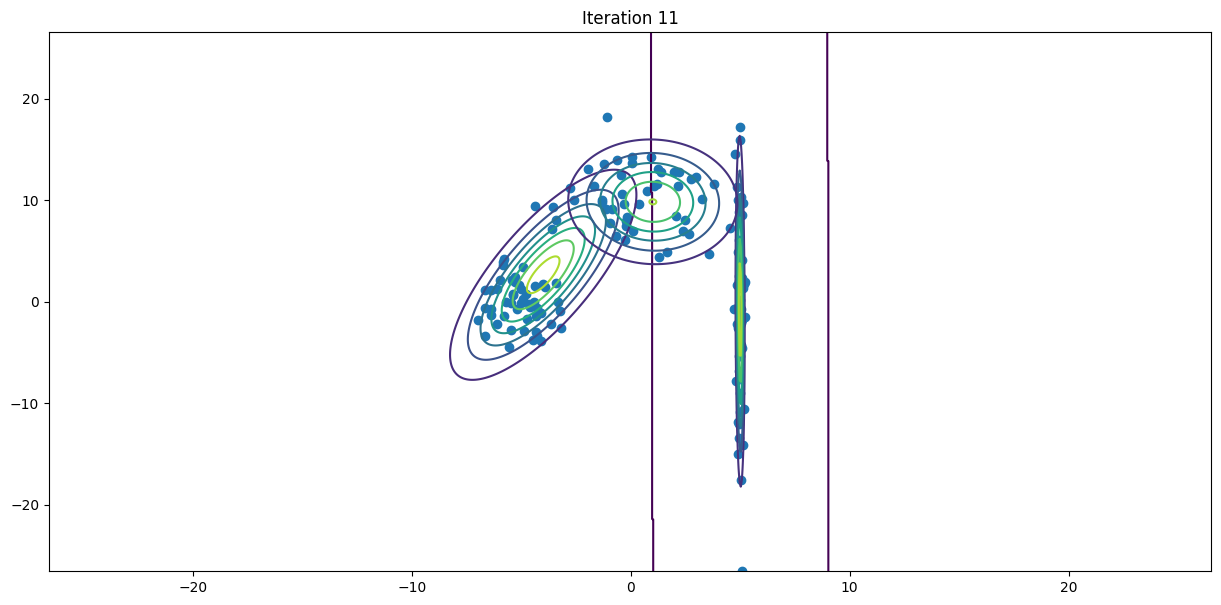

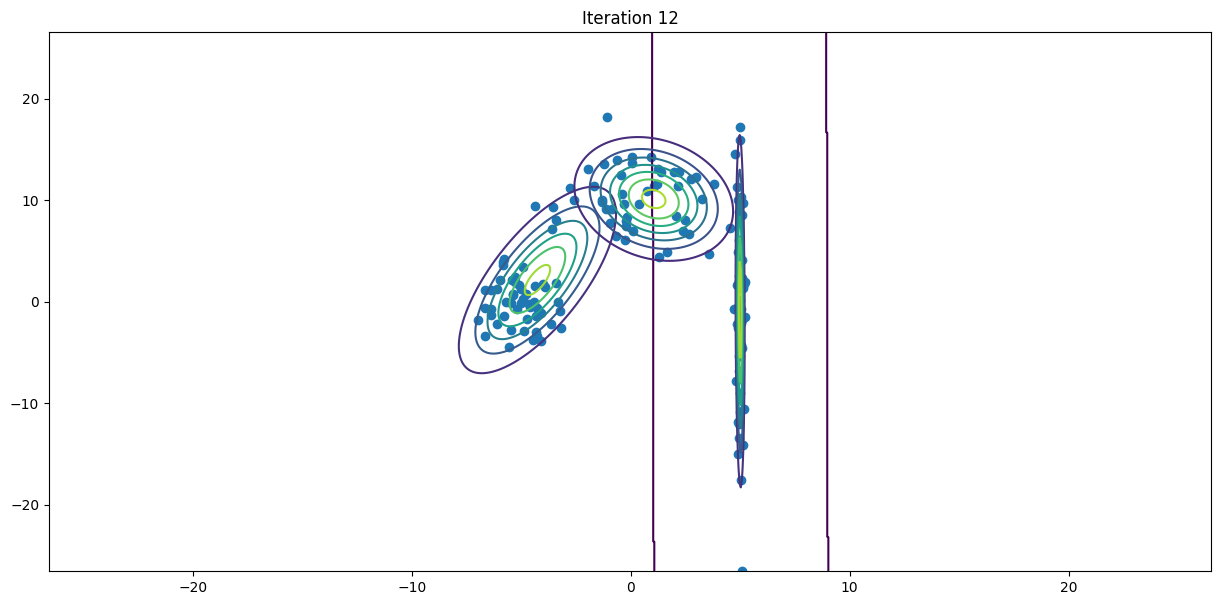

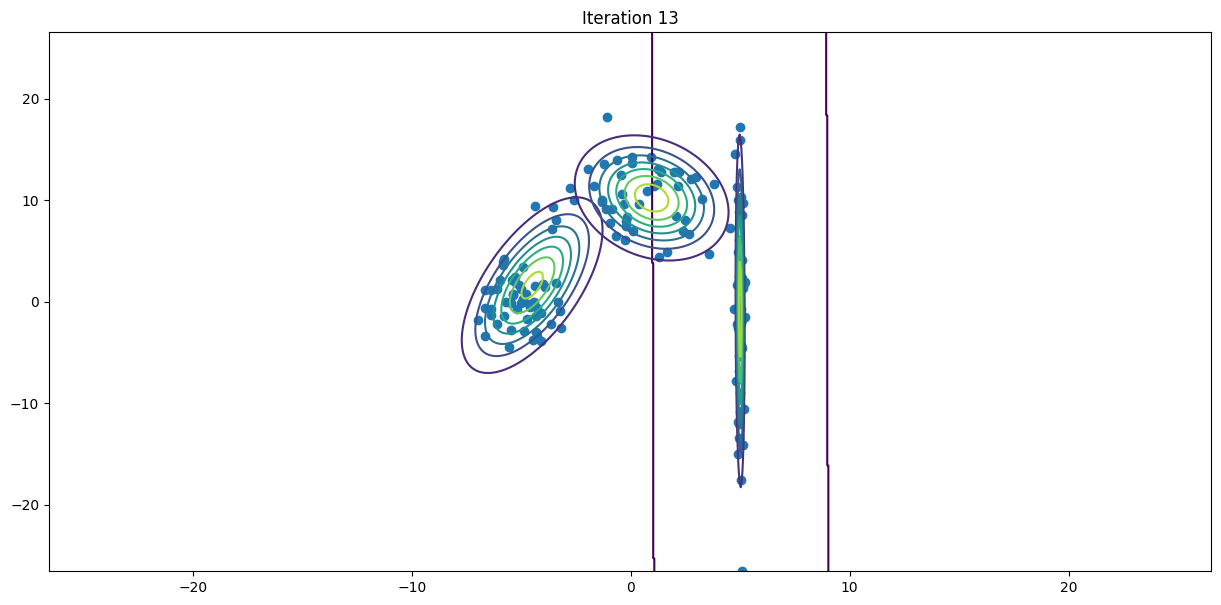

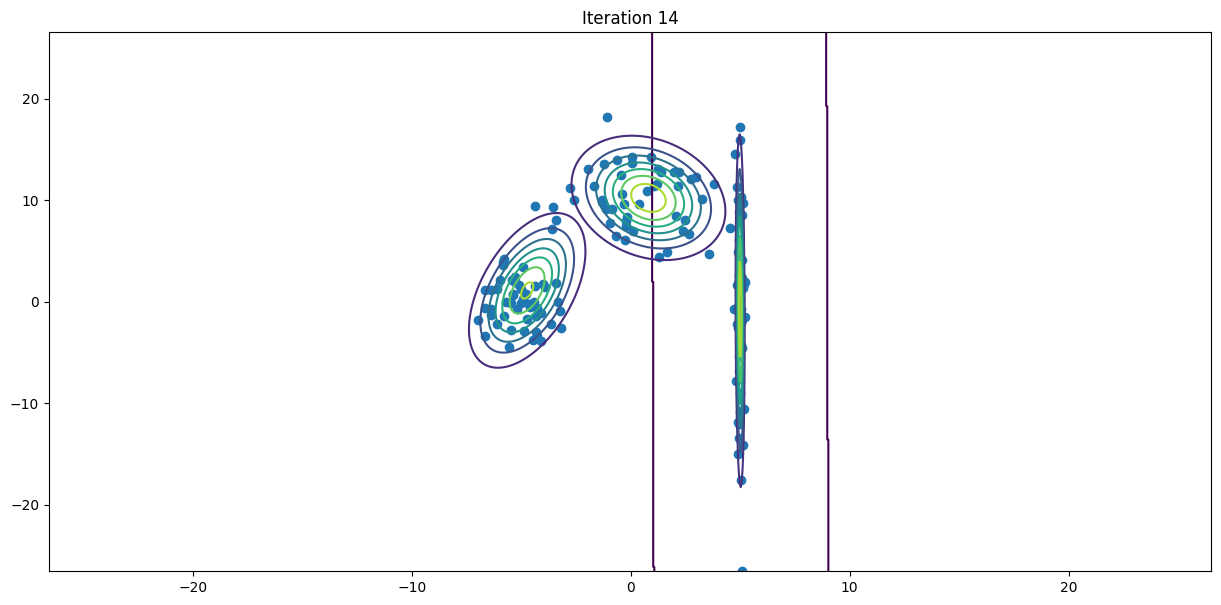

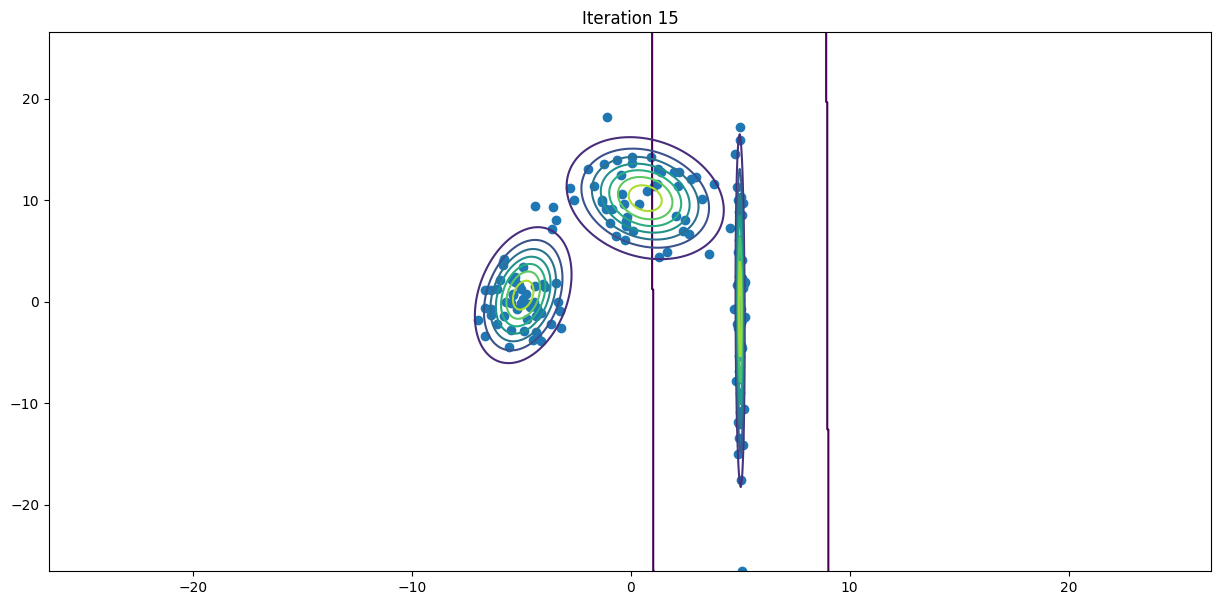

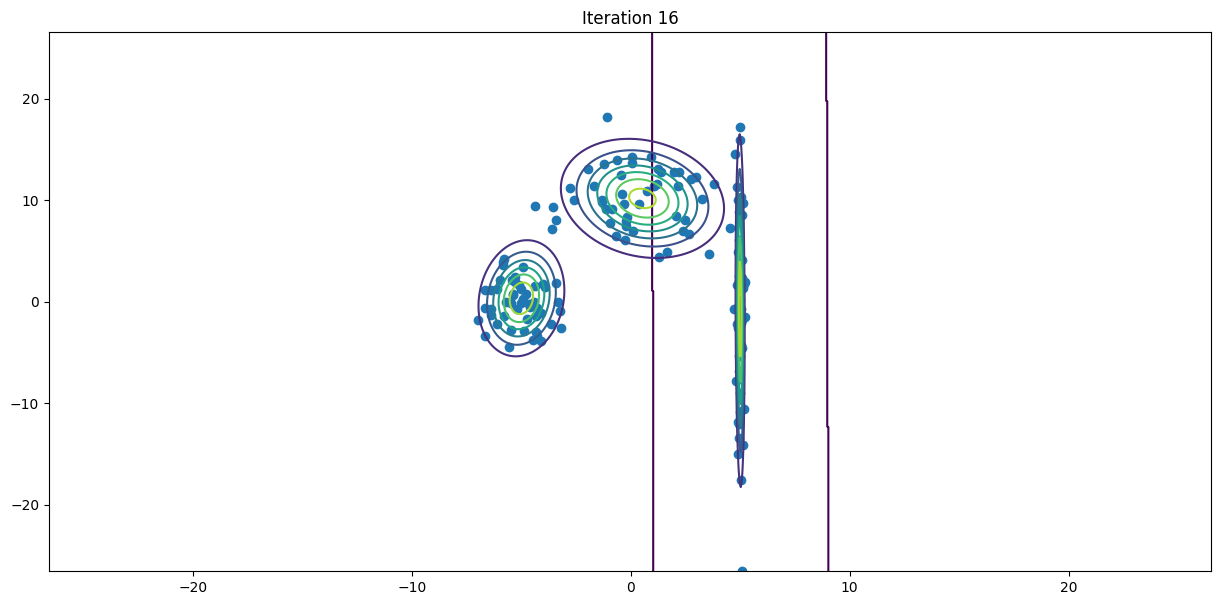

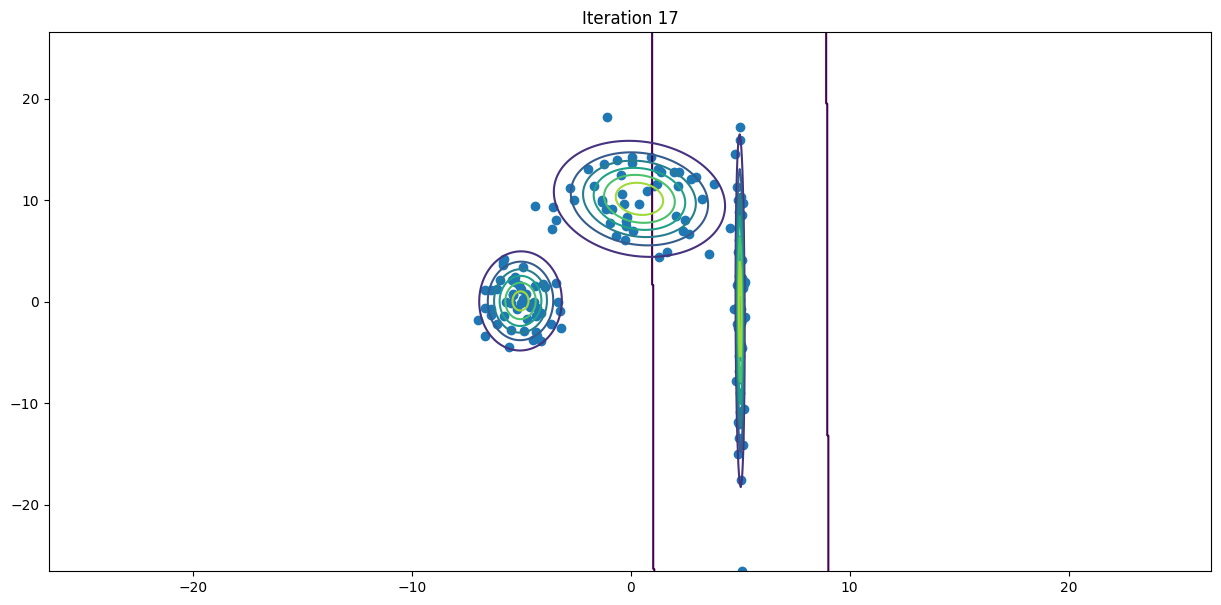

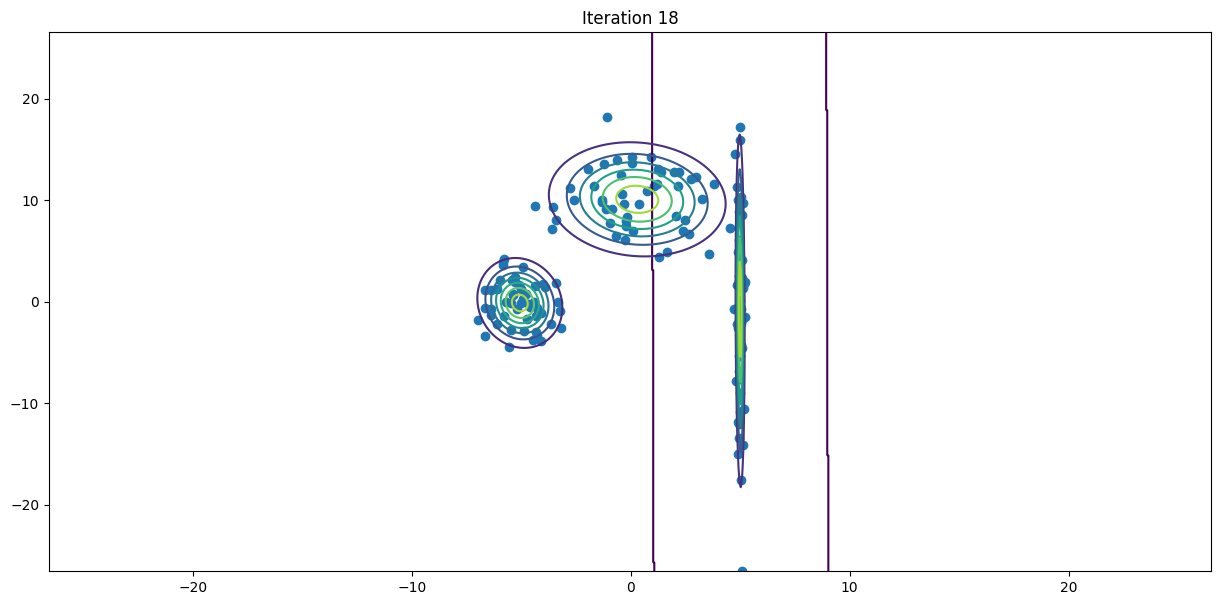

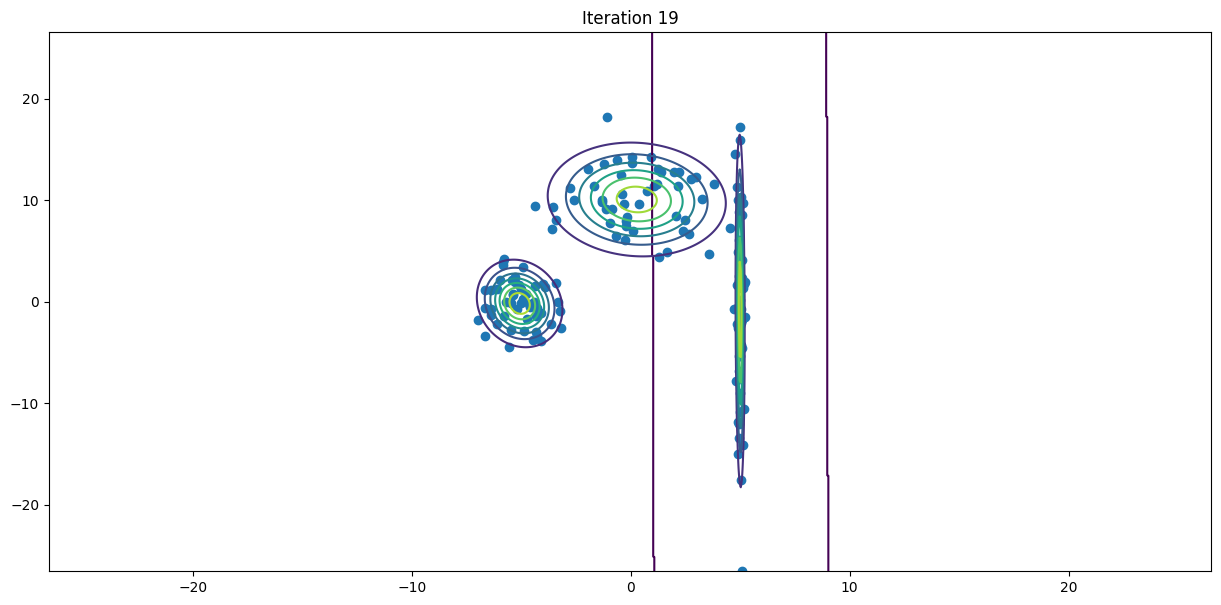

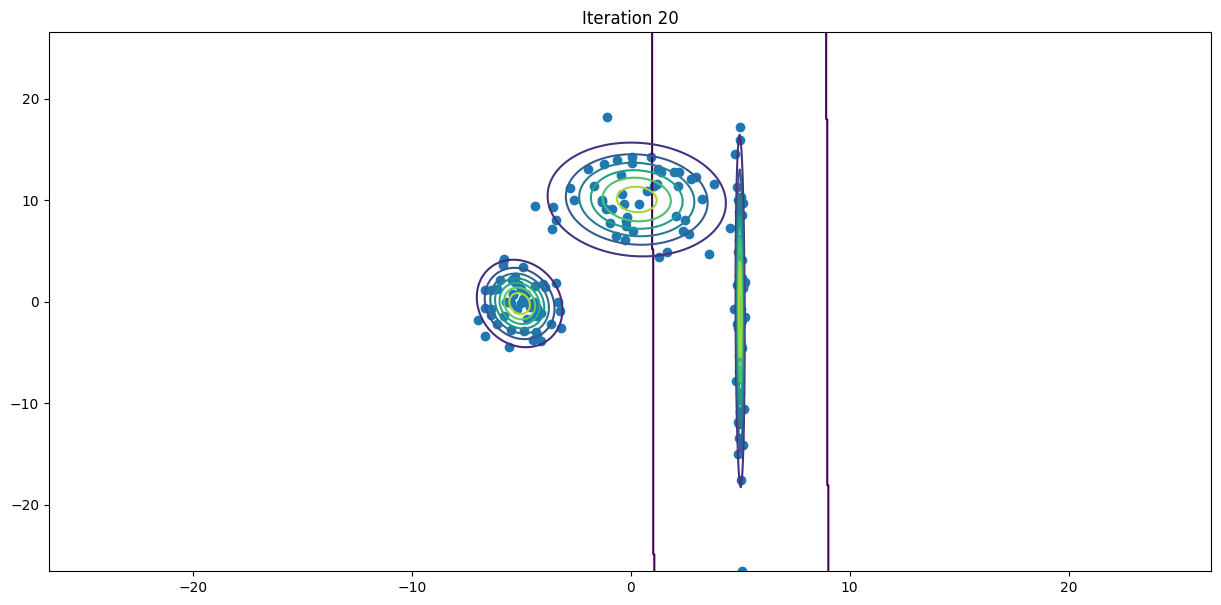

In [20]:
# Depending on your implementation this cell might take a while to run... (this is mainly due to the plots)
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(X, K, 150, plot_intermediate=True)

Text(0, 0.5, 'Log likelihood')

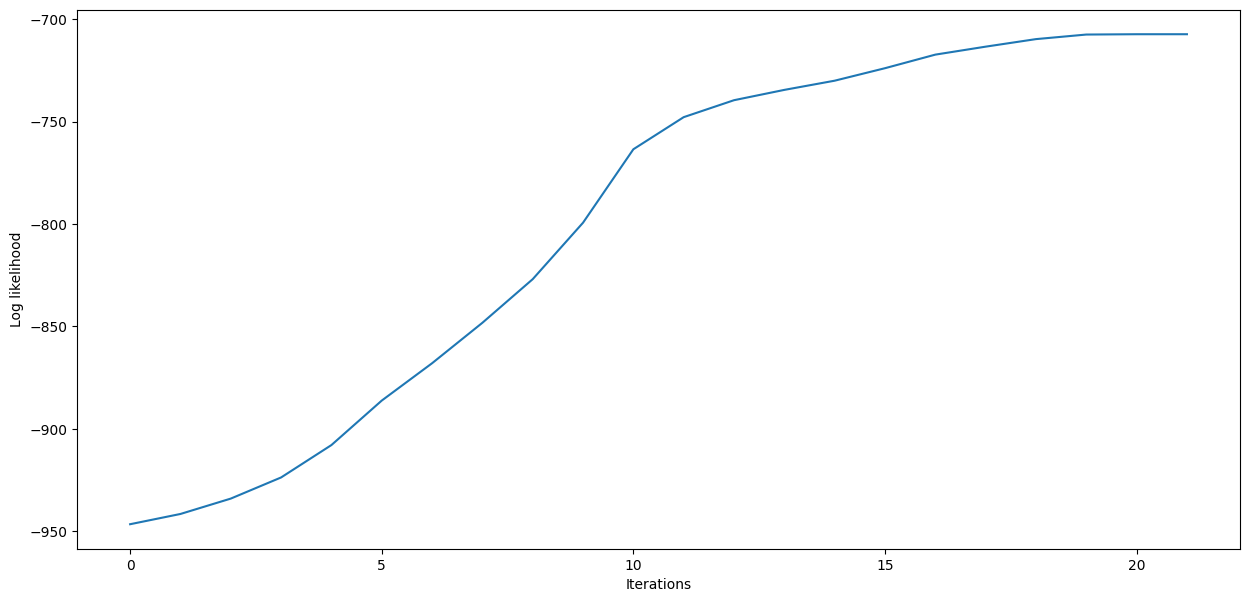

In [21]:
plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

## TODO 7: explain the results you got (max 10 lines)

1-D dataset:
- Compare plots in Todo 4 with the ones in Todo 6, what has changed? Is EM providing us a meaningful clustering? 

2-D dataset:
- Why is the log likelihood monotonically increasing? Is this what you expect from the theory? Compare both log likelihood trajectory and 2-d plots.
- Is delta log likelihood monotonically going to zero?  
- Which termination criterion is met first?

(Answer in the next cell, no need to add code)

YOUR ANSWER HERE

1-D dataset: 
 - In Todo 4 the distributions according to which the datapoints are labelled are ones those that have **predefined** parameters $\pi_{l}, \mu_{l} , \Sigma_{l}$ per l-th cluster, and the EM algorithm *hasn't run yet* (only the E step so as to obtian the weights), therefore we don't see the most meanigful clustering. In Todo 6, the distributions label the data well, as now EM has run till convergence (one of the stopping conditions) and each Gaussian component has shifted and adjusted their parameters($\pi_{l}, \mu_{l} , \Sigma_{l}$) so as to correspond to a distinct cluster, based on the likelihood under each Gaussian component.

2-D dataset: 
- The reason the log likelihood is monotonically increasing is because EM is designed in such a way. **Yes, this can be backed up by theory**. The E-step calculates the *posterior probabilities (weights)* for each datum, given the current parameters, this creates a lower bound that touches the current likelihood and the M-step updates these parameters increasing the lower bound, and hence the new log likelihood must be above this, it can be verified via the result of the E-step $$Q(\theta, \theta^{'} ) \le \log \left(p_\theta(x)\right)+\underbrace{\mathbf{E}_{p_{\theta^{\prime}}(z \mid x)} \log \left(p_{\theta^{\prime}}(z \mid x)\right)}_{=C} $$  
- No, the delta log likelihood is not guranteed to be monotonically going to zero. The overall trend is decreasing because EM ensures to increase the log likelihood or remain constant **however the improvement (delta) is not necessarily monotonic,** as that depends on the nature of the E-step & M-step update, initial parameters and the data distribution.
- The **convergence termination condition is met first** because at the start the model parameters are far from optimal, and larger delta log likelihood are present, it slows down and starts to plateau, leading to the specific epsilon threshold on improvement not being met anymore as its reached a local or global maximum. The speed of convergence is impacted by the initial conditions as well.  

In [22]:
# What is the effect of choosing a different number of classes?
centers = [[-2, 0], [0, 3], [2, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=20, n_samples=150, shuffle=True)

Ks = [2, 3, 4, 5, 6]
results = []
for k in Ks:
    results.append(run_EM_on_GMM(X, k, 150, plot_intermediate=False))

Iteration 0, log likelihood -800.8496,  delta log likelihood 0.8911
Iteration 1, log likelihood -799.2145,  delta log likelihood 1.6351
Iteration 2, log likelihood -796.5460,  delta log likelihood 2.6685
Iteration 3, log likelihood -793.7546,  delta log likelihood 2.7914
Iteration 4, log likelihood -791.9021,  delta log likelihood 1.8526
Iteration 5, log likelihood -790.7830,  delta log likelihood 1.1191
Iteration 6, log likelihood -789.9674,  delta log likelihood 0.8156
Iteration 7, log likelihood -789.2069,  delta log likelihood 0.7605
Iteration 8, log likelihood -788.3890,  delta log likelihood 0.8180
Iteration 9, log likelihood -787.4364,  delta log likelihood 0.9525
Iteration 10, log likelihood -786.2262,  delta log likelihood 1.2102
Iteration 11, log likelihood -784.4756,  delta log likelihood 1.7506
Iteration 12, log likelihood -781.4370,  delta log likelihood 3.0386
Iteration 13, log likelihood -774.9510,  delta log likelihood 6.4859
Iteration 14, log likelihood -760.9013,  del

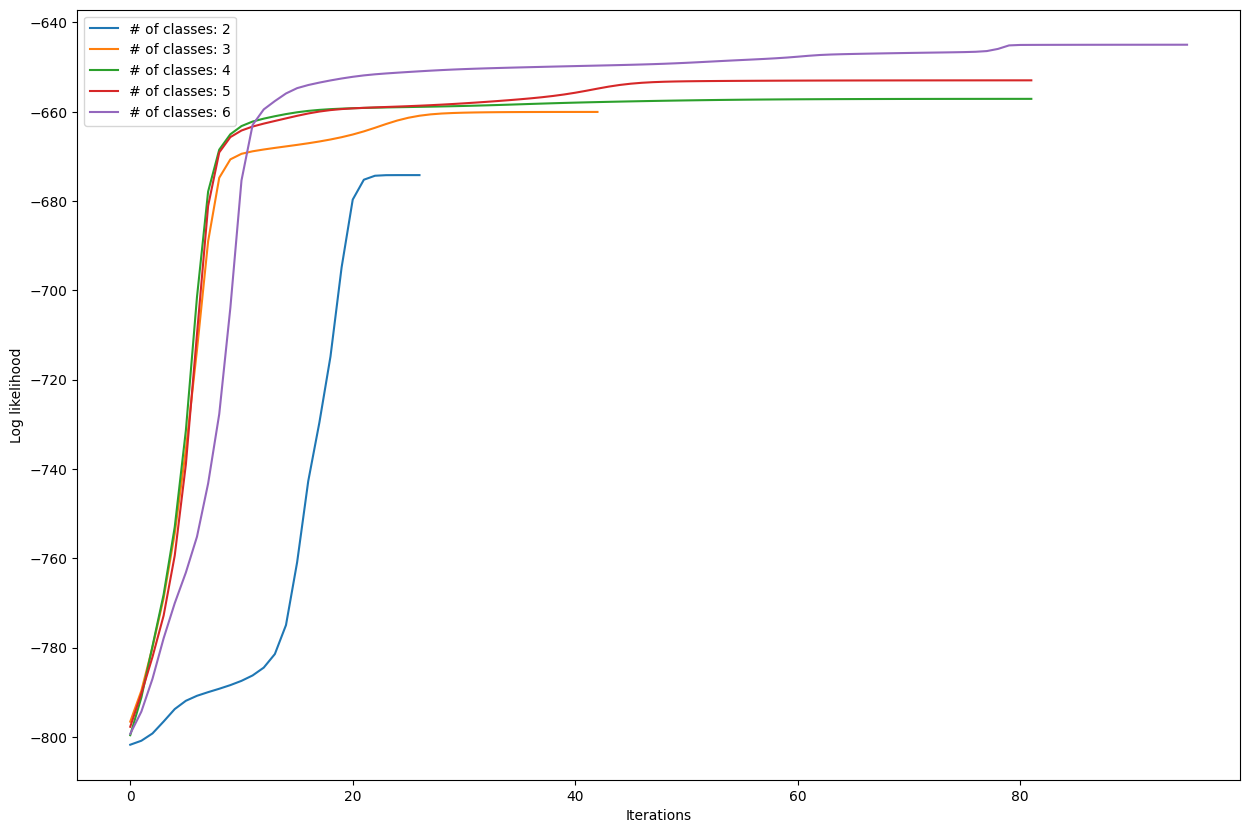

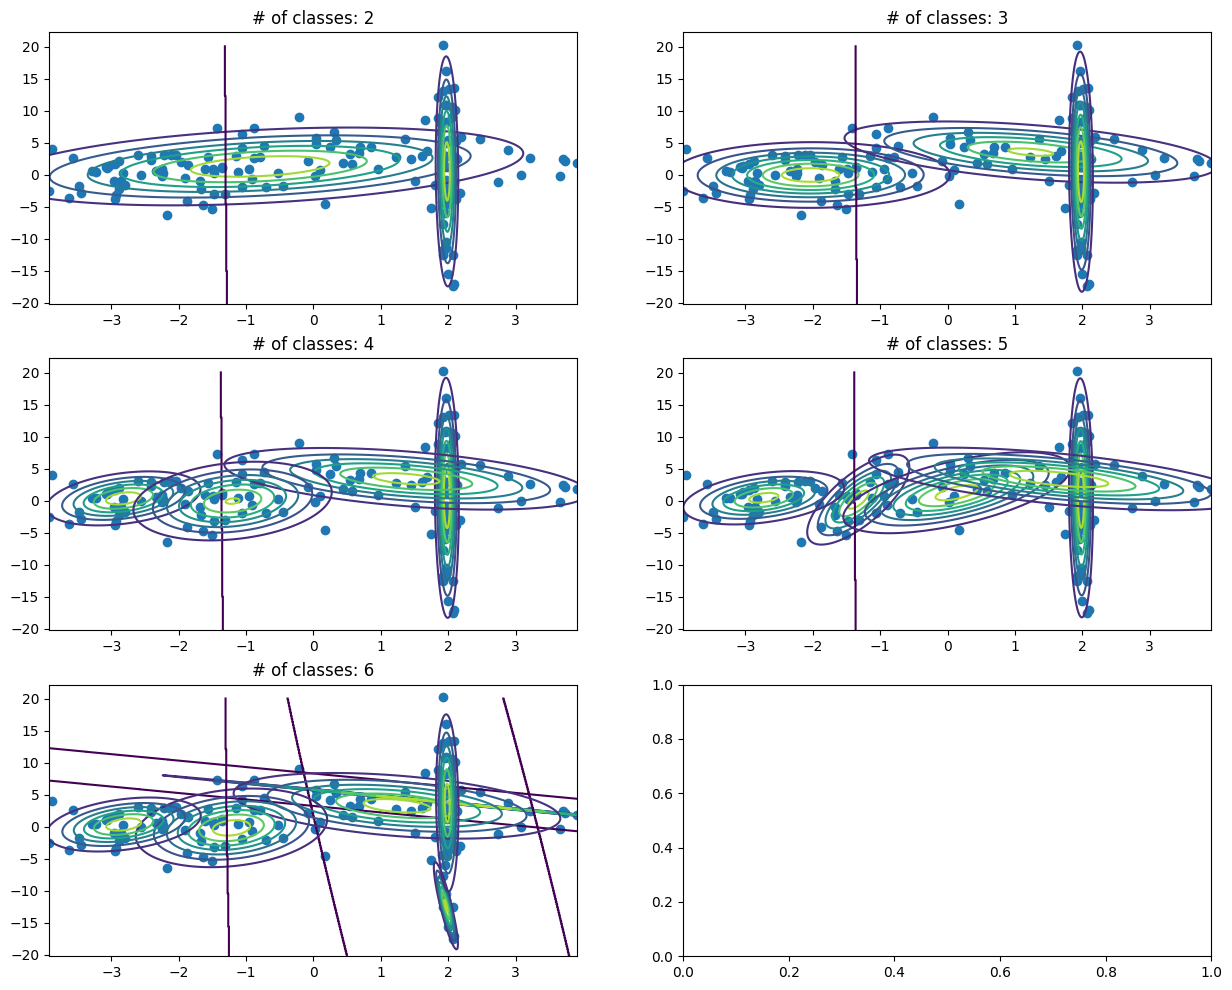

In [23]:
# Let's plot the log likelihood trajectories and the final 2-d Clustering
plt.figure(figsize=(15,10))
for res, k in zip(results, Ks): 
    plt.plot(np.array(res[-1]), label=f'# of classes: {k}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

x_max, y_max = np.max(np.abs(X[:,0])), np.max(np.abs(X[:,1]))
x, y = np.mgrid[-x_max:x_max:.01, -y_max:y_max:.01]
pos = np.dstack((x, y))

fig, axes = plt.subplots(3, 2, figsize=(15,12))
# Plot scatter plot of training data and corresponding clusters    
for (_, pi, means, covs, _), K, ax in zip(results, Ks, axes.reshape(-1,)): 
    for k in range(K):
        ax.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos), )
    ax.scatter(X[0:,0], X[0:,1])
    ax.set_title(f'# of classes: {K}')

# MNIST clustering

Let's apply GMM to a slightly more complex dataset: MNIST (which we already encountered in the last homework).

In the following we shall use the sklearn implementation of the EM.

Once we fit the GMM we shall visualize the centers in order to evaluate whether the clustering algorithm came up with a meaningful solution (in an ideal scenario we would expect to have each center representing one single digit).

In [24]:
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture
import sklearn

X, Y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)
    
X = X / 255.

from sklearn.model_selection import train_test_split

m_t = 5000
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=m_t/len(Y), random_state=ID_number, 
                                                    stratify=Y)

# Function to plot a digit and print the corresponding label
def plot_digit(vect_img, ax, cluster_id=None):
    ax.set_title(f'Cluster ID: {cluster_id}')
    ax.imshow(
        vect_img.reshape(28,28),
        cmap          = 'gray',
        interpolation = "nearest"
    )

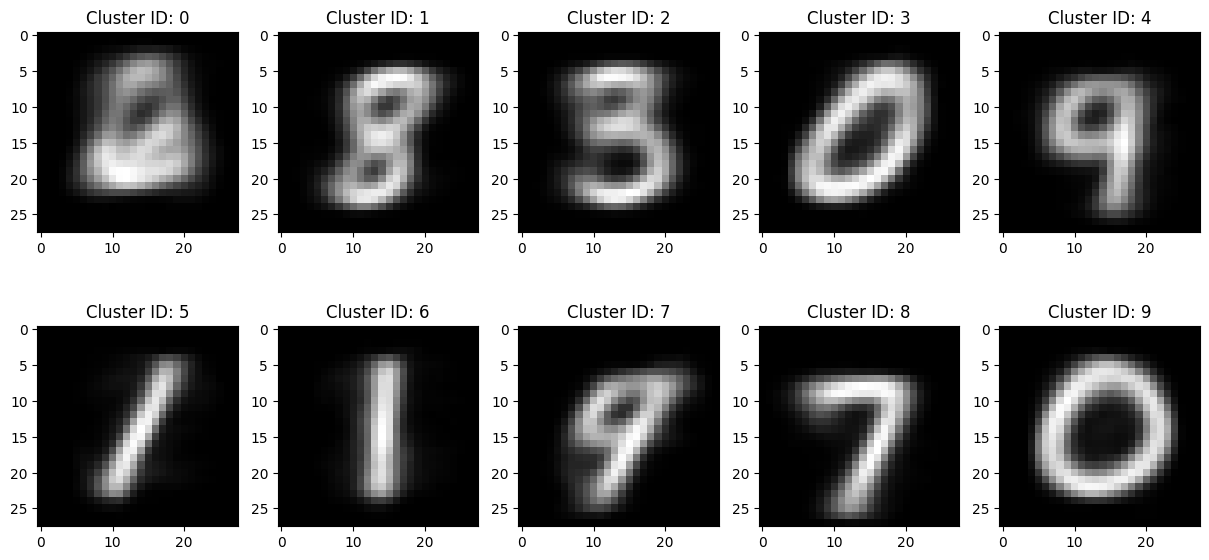

In [25]:
# TODO 8: use GaussianMixture from skelearn to cluster x_train and then predict the labels.
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 10
# When you initialize the GaussianMixture object set random_state=ID_number
gmm = None
gmm_pred = None
# YOUR CODE HERE
gmm = GaussianMixture(n_components=K, random_state=ID_number).fit(x_train)
# train or test? 
gmm_pred = gmm.predict(x_train)

plt1, axes = plt.subplots(2, K // 2, figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)   

In [26]:
assert gmm_pred.shape == (m_t,)

The weight used for initialization are [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


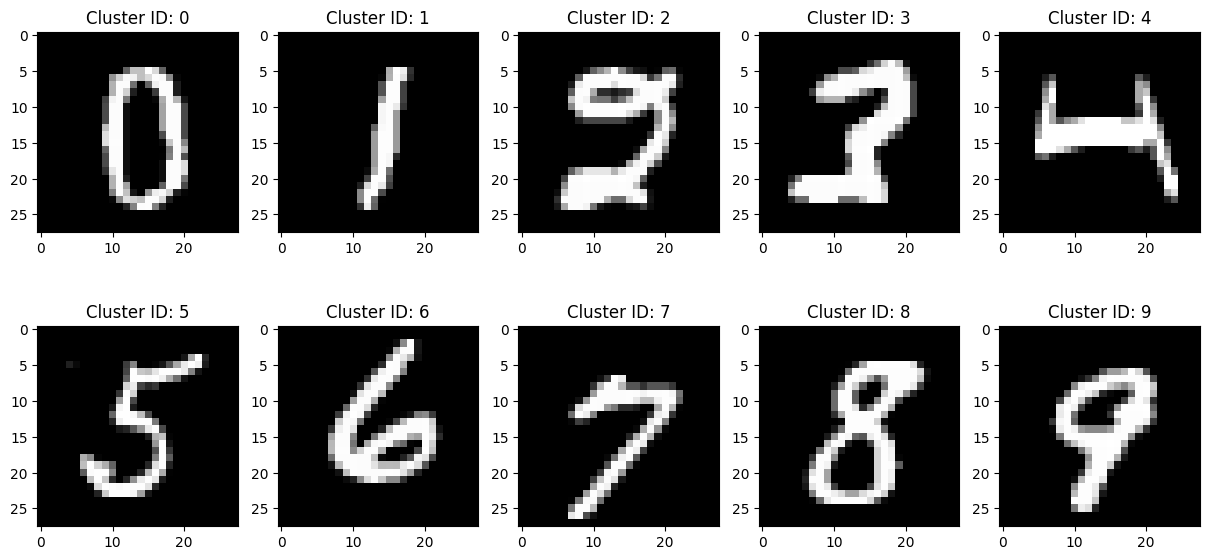

In [27]:
# let's try to initialize the means of the gmm using the first instance of each digit (0-9) present in the training set.

means = np.zeros((10, x_train.iloc[0].to_numpy().reshape(1,-1).shape[1]))
weights = np.ones((1,10))[0]*1/K

for k in range(10):
    first_numb = 0
    while not (int(y_train.iloc[first_numb]) == k):
        first_numb = first_numb+1
    means[k,:] = x_train.iloc[first_numb].to_numpy().reshape(1,-1)

# print the digits used for initialization
plt2, axes = plt.subplots(2, K // 2,figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(means[k], ax, cluster_id=k)

# print the weights used for initialization    
print(f'The weight used for initialization are {weights}')

In [28]:
# training the gmm
gmm = None
gmm = GaussianMixture(n_components=K, weights_init = weights,means_init = means)
gmm_pred = gmm.fit_predict(x_train)

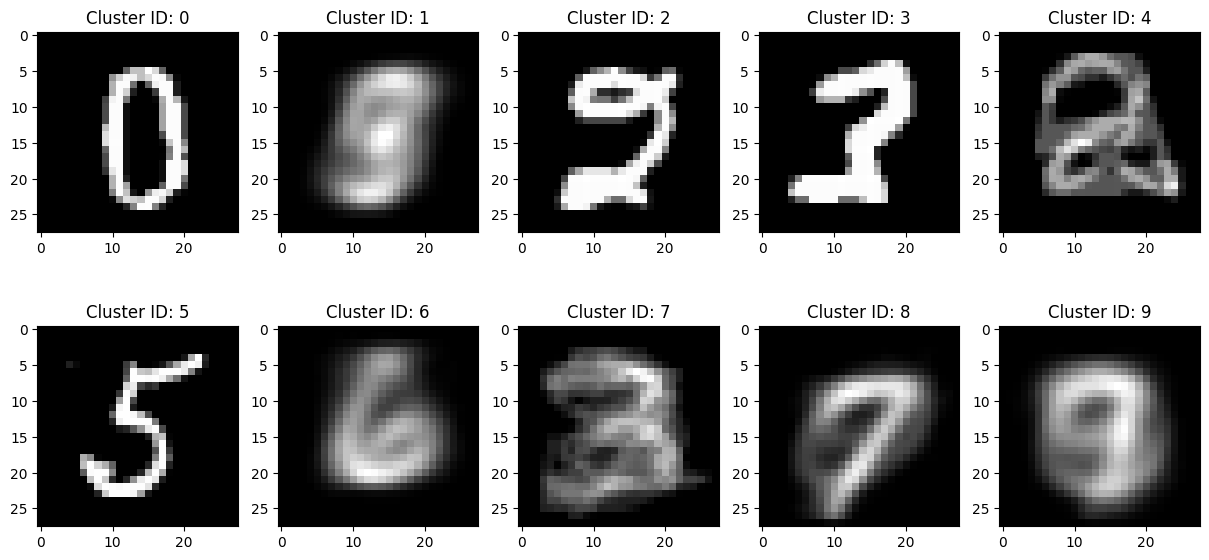

In [29]:
# plotting the means
plt3, axes = plt.subplots(2, K // 2,figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)

# Comparison with supervised models: 
In the next cell we shall compare Unsupervised methods (Kmeans and GMM) with a
Supervised method (NNs) on MNIST. 
Note that supervised methods cannot be applied in the unsupervised setting (i.e. we do not have any label). 
Nonetheless we can apply an unsupervised method to a supervised problem (we just need to neglect the extra piece 
of information we have: the labels). 
In the following we shall train both Kmeans and GMM as if we do not have labels and then we shall compare their
predictions to the ground truth labels. 

NOTE: in an unsupervised scenario we are not able to compare model predictions with ground truth labels since 
labels are not part of the problem statement.

In [30]:
y_train = y_train.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)

In [31]:
# TODO 9: 
# Remember in ANY unsupervised clustering algorithm the name of the cluster DOES NOT possess any meaning. 
# The first class of the GMM model trained on the MNIST dataset does not necessarily represent the digits "0". 
# You can see this on the previous plots (plots of the centers of each component).
# Therefore we need to find a way to convert model clusters (predictions) to ground truth labels. Several choices 
# are possible, in the following we shall use a very simple and straightforward rule: 
# 1- Find all the indeces of the data belonging to the same cluster predicted by the clustering model
# 2- Use these indeces (in the dataset) to gather the true labels
# 3- Compute the mode on the choosen true labels
# 4- Assign the mode as the new name of the cluster.
# In this way we are able to compare model predictions with the true labels (ground truth labels) and we can 
# compute the number of missclassified examples (as we did in previous Classification HWs). 

from scipy.stats import mode
def convert_prediction_labels(targets : np.ndarray, predictions : np.ndarray, num_clusters : int) -> np.ndarray:
    '''
    Function to assign a different label to the predictions of a clustering algorithm. Use the 4 steps described 
    earlier.
    :param targets: True labels (of shape (N,))
    :param predictions: Labels predicted by the clustering algorithm (of shape (N,))
    :param num_clusters: # of clusters in the training dataset
    :returns: 
        pred_labels: new labels for each datum (of shape (N,))
    '''
    pred_labels = np.zeros_like(targets)
    for k in range(num_clusters):
        # YOUR CODE HERE

        #1- All indeces of the data belonging to the same cluster predicted by the clustering model
        indeces = np.where(predictions == k)[0]

        #2 - True labels in the target
        true_labels = targets[indeces]

        #3 - Mode of the true labels 
        if len(true_labels) > 0: 
            common_label = mode(true_labels).mode[0]
        else: 
            common_label = -1 # if the cluster has no datapoints assigned to it

        pred_labels[indeces] = common_label

    return pred_labels

def compute_score(targets, predictions, num_clusters):
    pred_labels = convert_prediction_labels(targets, predictions, num_clusters)
    errors = sum(pred_labels == targets)
    return (1 - errors / len(targets))

In [32]:
assert convert_prediction_labels(y_train, gmm_pred, 10).shape == (m_t,)

In [33]:
# TODO 10: Use sklearn GaussianMixture and KMeans to cluster x_train. Then evaluate the errors using the groud 
# truth labels (y_train) using the functions we built in the previous cell. Eventually we compare clustering 
# error rates with a supervised classification method: MLP.

# When you initialize the GaussianMixture and KMeans objects set random_state=ID_number
gmm, gmm_pred_train, gmm_pred_test = None, None, None
# YOUR CODE HERE

gmm = GaussianMixture(n_components=K, random_state=ID_number).fit(x_train)
gmm_pred_train = gmm.predict(x_train)
gmm_pred_test = gmm.predict(x_test)

gmm_tr_err   = compute_score(y_train, gmm_pred_train, K)
gmm_test_err = compute_score(y_test, gmm_pred_test, K)
print(f'GMM Training err    {gmm_tr_err:.4f}, Test err {gmm_test_err:.4f}')

from sklearn.cluster import KMeans
kmeans, kmeans_pred_train, kmeans_pred_test = None, None, None
# YOUR CODE HERE

kmeans = KMeans(n_clusters=K, random_state=ID_number).fit(x_train)
kmeans_pred_train = kmeans.predict(x_train)
kmeans_pred_test = kmeans.predict(x_test)

kmeans_tr_err   = compute_score(y_train, kmeans_pred_train, K)
kmeans_test_err = compute_score(y_test, kmeans_pred_test, K)
print(f'Kmeans Training err {kmeans_tr_err:.4f}, Test err {kmeans_test_err:.4f}')


from sklearn.neural_network import MLPClassifier
best_mlp_large = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, 
                               random_state=ID_number, learning_rate_init=.1)
best_mlp_large.fit(x_train, y_train)
training_error = 1. - best_mlp_large.score(x_train, y_train)
test_error = 1. - best_mlp_large.score(x_test, y_test)

print(f'MLP Training err {training_error:.4f}, Test err {test_error:.4f}')

GMM Training err    0.3862, Test err 0.5990
Kmeans Training err 0.4240, Test err 0.4184
MLP Training err 0.0000, Test err 0.0611


In [34]:
assert gmm_pred_train.shape == (m_t,)
assert gmm_pred_test.shape == (70000 - m_t,)
assert kmeans_pred_train.shape == (m_t,)
assert kmeans_pred_test.shape == (70000 - m_t,)

## TODO 11 (max 10 lines)

- What is the effect of a wrong choice of the number of clusters? Briefly describe both log-likelihood as a function of iterations and optimal clustering (depicted on the 2-D plot). 
- What does the 10 different plots in TODO 8 represent, with respect to the GMM approach? Would you expect that they may change depending on the initialization?
- The number of errors using GMM on MNIST is quite high, could have you predicted such a behaviour looking only at the plots in TODO 8? Why? Could they be better changing initialization?
- Compare GMM, Kmeans and NN. Which is the best model? Why? Did you expect the result? 


(Answer in the next cell, no need to add code)

YOUR ANSWER HERE

- The result of incorrect number of clusters can lead to *underfitting or overfitting* of our model, when there are very few clusters *(high bias)* the model tends to force several datum into the same cluster resulting in a oversimplification of the underlying distribution, like in the first subplot (two clusters, but we have three distinct groups), and too many clusters *(high variance)* like in the last subplot which leads to a reduction in generalization. The log-likelihood monotonically increases as a function of iterations at the start the log-likelihood curve, starts low and gradually increases as the parameters are tuned to finally flatten out. The 2D plots initially are far from optimal and as the log-likelihood increases, so do the Gaussians represent the data better. If the clustering is optimal the curve would be smooth, with a monotonic increase, and quick convergence. 

- In TODO 8 the plots represent *how GMM clusters the MNIST dataset and predicts the labels*. **Yes, different initilization leads to a different result**, as if the initilization would place the cluster centers closer to its true centers, we would converge to a local optima or global optimum faster. 

- Yes, when we observe TODO 8 it is immediate to notice that the performance is not optimal, and GMM is unable to capture the distribution, leading to a digit overlap across clusters. For the following reasons: 
    - *High Dimensionality*: MNIST has 784 dimensions, leading to a higher probability of the random initilization falling far from its true value. 
    - *Gaussian Assumptions and pixel intensity averaging*: MNIST often violates this, for example the stroke length, thickness and style vary per digit. Due to the same reason the means of the clusters can look blurry, because of the variations present. **Yes, they could be better by changing the initialization**, for the same reason mentioned in the previous point. An approach to get a *better* solution could be running GMM multiple times with different initializations, and selected the one with the best log likelihood. 

- 
    | **Model**               | **Performance on MNIST**          | **Advantages**                                                                                 | **Disadvantages**                                                                           |
    |--------------------------|------------------------------------|------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
    | **Gaussian Mixture Model (GMM)** |Training err    0.3862, Test err 0.5990 | Captures soft assignments and variance in clusters. Can model non-spherical clusters.  | Sensitive to initialization due to high-dimensional data.    |
    | **K-means**             | Training err 0.4240, Test err 0.4184 | Simple and fast to implement. Works well with spherical clusters and low-dimensional data.   | Assumes spherical clusters. Doesn't model variance within clusters. Limited flexibility.   |
    | **Multilayer Perceptron (MLP)** |  Training err 0.0000, Test err 0.0611| Highly accurate on MNIST. Can model complex, nonlinear relationships.                       | Requires labeled data. Computationally expensive. Requires significant training time.      |

    NN (MLP) is by far the best model as it has *no missing data (labels)* and it can *capture non-linear relationships* well due to its interconnected layers with non-linear activation functions (relu, sigmoid). Yes I did expect the same as in comparison to UL methods such as GMM & Kmeans in a high-dimensionality, noisy environment with overlapping features don't perform well. 
